In [1]:
import pandas as pd
import numpy as np


In [2]:
train_df = pd.read_csv('/Users/iswetha/Downloads/archive/train.csv')
train_df.head()

id                                                url  \
0  97c0a12e07ae8dd5  http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...   
1  650c989dd3493748  https://lh5.googleusercontent.com/-PUnMrX7oOyA...   
2  05e63ca9b2cde1f4  http://mw2.google.com/mw-panoramio/photos/medi...   
3  08672eddcb2b7c93  http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...   
4  fc49cb32ef7f1e89  http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...   

  landmark_id  
0        6347  
1       12519  
2         264  
3       13287  
4        4018

In [3]:
train_df.shape

(1225029, 3)

In [4]:
train_df.dtypes

id             object
url            object
landmark_id    object
dtype: object

In [5]:
# Looking for null values in the dataset
train_df.isna().sum()

id             0
url            0
landmark_id    0
dtype: int64

In [6]:
train_df.isnull().values.any()

False

In [7]:
# Now try to open the URL
temp = 4444
print('id', train_df['id'][temp])
print('url:', train_df['url'][temp])
print('landmark id:', train_df['landmark_id'][temp])

id 3d0306b47190ca76
url: https://lh6.googleusercontent.com/-HFAffAIWWc4/UtUIeWDHY6I/AAAAAAAAQzw/0W2XAIkIJGI/s1600/
landmark id: 784


In [8]:
# Cleaning the dataset as found out there are some 'NONE' strings in the urls. 
dropped_rows = train_df.loc[train_df['url'] == 'None'].index
dropped_rows

Int64Index([     38,     121,     131,     175,     200,     204,     205,
                220,     426,     504,
            ...
            1224618, 1224641, 1224693, 1224752, 1224779, 1224799, 1224824,
            1224834, 1224875, 1224884],
           dtype='int64', length=34362)

In [34]:
dropped_rows.shape

(34362,)

In [9]:
# Dropped the NONE string from the dataset
train_df.drop(dropped_rows, inplace = True)


In [35]:
# Trying to find out the unique landmark_id in the dataset
train_df['landmark_id'].value_counts().shape

(14946,)

In [17]:
# Occurance of landmark_id in decreasing order(Top categories)
temp = pd.DataFrame(train_df.landmark_id.value_counts().head(13))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

landmark_id  count
0         9633  49451
1         6051  49222
2         6599  22762
3         9779  18062
4         2061  12998
5         5554  10800
6         6651   9296
7         5376   9048
8         6696   9030
9         2743   8821
10        4352   8820
11       13526   8501
12        1553   7649

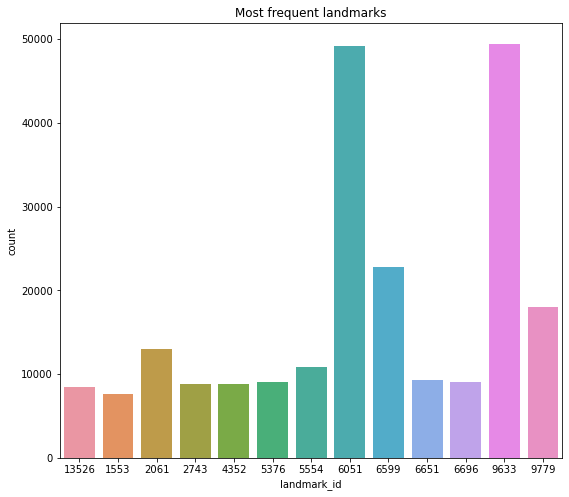

In [20]:
# Plot the most frequent landmark_ids
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (9, 8))
plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

In [21]:
# Occurance of landmark_id in increasing order
temp = pd.DataFrame(train_df.landmark_id.value_counts().tail(13))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

landmark_id  count
0         9519      1
1         5926      1
2         6147      1
3         6942      1
4         1033      1
5        10190      1
6        12452      1
7          952      1
8        10007      1
9        12825      1
10        1527      1
11        4058      1
12        5745      1

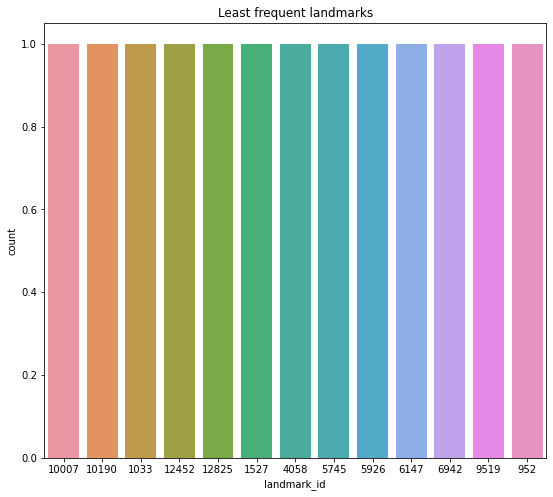

In [22]:
# Plot the least frequent landmark_ids
plt.figure(figsize = (9, 8))
plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

In [11]:


# key_map_old = {
#     9633: san_pietro,
#     6051: colosseum,
#     6599: willis_tower, #chicago  #no
#     1553: berlin_cathedral,
#     2743: pantheon,
#     5554: petronas_towers,
#     6651: florence, #no
#     8063: hagia_sophia,
#     9779: el_partal,
#     10900: commerzbank_tower # frankfurt
# }


key_map = { 
    "9633": "san_pietro",
    "6051": "colosseum",
    "9779": "el_partal",
    "2061": "",
    "5554": "petronas_towers",
    "5376": "",
    "6696": "",
    "2743": "pantheon",
    "4352": "",
    "13526": "",
    "1553": "berlin_cathedral",
    "10900": "commerzbank_tower",
    "8063": "hagia_sophia"
}

keys = list(key_map.keys())


In [24]:
frames = {}

for elem in keys:
    frame = train_df.loc[train_df["landmark_id"] == elem]
    print(elem + " -> " + str(frame.shape))
    frames[elem] = frame

len(frames)
    

9633 -> (49451, 3)
6051 -> (49222, 3)
9779 -> (18062, 3)
2061 -> (12998, 3)
5554 -> (10800, 3)
5376 -> (9048, 3)
6696 -> (9030, 3)
2743 -> (8821, 3)
4352 -> (8820, 3)
13526 -> (8501, 3)
1553 -> (7649, 3)
10900 -> (6826, 3)
8063 -> (6487, 3)


13

In [25]:
import pathlib
import tensorflow as tf
import os
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
import traceback

base_directory = "/Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads"

train_directory = '{}/train'.format(base_directory)
test_directory = '{}/test'.format(base_directory)


train_count = 1600
test_count = 400

# for each key
for key in keys:
    train_urls = frames[key]["url"][0:train_count].values
    test_urls = frames[key]["url"][train_count:train_count+test_count].values
    
    # Download training images
    for index, url in enumerate(train_urls, start=1):
        folder_path = '{}/{}'.format(train_directory, key)
        filename = 'image_{}.jpg'.format(index )
        file_path = '{}/{}'.format(folder_path, filename)
        
        
        os.makedirs(folder_path, exist_ok=True)

        if os.path.exists(file_path):
            print('Image %s already exists. Skipping download.' % file_path)
            continue

        try:
            response = urlopen(url)
            image_data = response.read()
        except Exception as err:
            traceback.print_exc()
            print('Warning: Could not download image %s from %s' % (filename, url))
            continue

        try:
            pil_image = Image.open(BytesIO(image_data))
        except Exception as err:
            traceback.print_exc()
            print('Warning: Failed to parse image %s' % filename)
            continue

        try:
            pil_image_rgb = pil_image.convert('RGB')
        except Exception as err:
            traceback.print_exc()
            print('Warning: Failed to convert image %s to RGB' % filename)
            continue

        try:
            pil_image_rgb.save(file_path, format='JPEG', quality=90)
            print('Success: Saved image %s' % filename)
        except Exception as err:
            traceback.print_exc()
            print('Warning: Failed to save image %s' % filename)
            continue
    
    # Download testing images
    for index, url in enumerate(test_urls, start=1):
        folder_path = '{}/{}'.format(test_directory, key)
        filename = 'image_{}.jpg'.format(index)
        file_path = '{}/{}'.format(folder_path, filename)
        
        os.makedirs(folder_path, exist_ok=True)

        if os.path.exists(file_path):
            print('Image %s already exists. Skipping download.' % file_path)
            continue

        try:
            response = urlopen(url)
            image_data = response.read()
        except Exception as err:
            traceback.print_exc()
            print('Warning: Could not download image %s from %s' % (filename, url))
            continue

        try:
            
            pil_image = Image.open(BytesIO(image_data))
        except Exception as err:
            traceback.print_exc()
            print('Warning: Failed to parse image %s' % filename)
            continue

        try:
            pil_image_rgb = pil_image.convert('RGB')
        except Exception as err:
            traceback.print_exc()
            print('Warning: Failed to convert image %s to RGB' % filename)
            continue

        try:
            pil_image_rgb.save(file_path, format='JPEG', quality=90)
            print('Success: Saved image %s' % file_path)
        except Exception as err:
            traceback.print_exc()
            print('Warning: Failed to save image %s' % filename)
            continue
    


Success: Saved image image_1.jpg
Success: Saved image image_2.jpg
Success: Saved image image_3.jpg
Success: Saved image image_4.jpg
Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg
Success: Saved image image_14.jpg
Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg
Success: Saved image image_20.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg
Success: Saved image image_28.jpg
Success: Saved image image_29.jpg
Success: Saved image image_30.jpg
Success: Saved image image_31.jpg
Success: Saved image image_32.jpg
Success: Saved image image_33.jpg
Success: Saved image image_34.jpg
Success: Saved image image_35.jpg
Success: Saved image image_36.jpg
Success: Saved image image_37.jpg
Success: Saved image image_38.jpg
Success: Saved image image_39.jpg
Success: Saved image image_40.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f04894a0>
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py"

Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg
Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg
Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_82.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_84.jpg
Success: Saved image image_85.jpg
Success: Saved image image_86.jpg
Success: Saved image image_87.jpg
Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_109.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg
Success: Saved image image_115.jpg
Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_179.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg
Success: Saved image image_204.jpg
Success: Saved image image_205.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_207.jpg
Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_318.jpg
Success: Saved image image_319.jpg
Success: Saved image image_320.jpg
Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_325.jpg
Success: Saved image image_326.jpg
Success: Saved image image_327.jpg
Success: Saved image image_328.jpg
Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg
Success: Saved image image_371.jpg
Success: Saved image image_372.jpg
Success: Saved image image_373.jpg
Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg
Success: Saved image image_408.jpg
Success: Saved image image_409.jpg
Success: Saved image image_410.jpg
Success: Saved image image_411.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_428.jpg
Success: Saved image image_429.jpg
Success: Saved image image_430.jpg
Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg
Success: Saved image image_452.jpg
Success: Saved image image_453.jpg
Success: Saved image image_454.jpg
Success: Saved image image_455.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg
Success: Saved image image_463.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_465.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg
Success: Saved image image_472.jpg
Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image image_484.jpg
Success: Saved image image_485.jpg
Success: Saved image image_486.jpg
Success: Saved image image_487.jpg
Success: Saved image image_488.jpg
Success: Saved image image_489.jpg
Success: Saved image image_490.jpg
Success: Saved image image_491.jpg
Success: Saved image image_492.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_512.jpg
Success: Saved image image_513.jpg
Success: Saved image image_514.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_516.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg
Success: Saved image image_533.jpg
Success: Saved image image_534.jpg
Success: Saved image image_535.jpg
Success: Saved image image_536.jpg
Success: Saved image image_537.jpg
Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg
Success: Saved image image_542.jpg
Success: Saved image image_543.jpg
Success: Saved image image_544.jpg
Success: Saved image image_545.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg
Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image image_558.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_560.jpg
Success: Saved image image_561.jpg
Success: Saved image image_562.jpg
Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_573.jpg
Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg
Success: Saved image image_577.jpg
Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg
Success: Saved image image_584.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_586.jpg
Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_606.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg
Success: Saved image image_616.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_618.jpg
Success: Saved image image_619.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg
Success: Saved image image_663.jpg
Success: Saved image image_664.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg
Success: Saved image image_675.jpg
Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg
Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image image_694.jpg
Success: Saved image image_695.jpg
Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_713.jpg
Success: Saved image image_714.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_716.jpg
Success: Saved image image_717.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg
Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg
Success: Saved image image_783.jpg
Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_788.jpg
Success: Saved image image_789.jpg
Success: Saved image image_790.jpg
Success: Saved image image_791.jpg
Success: Saved image image_792.jpg
Success: Saved image image_793.jpg
Success: Saved image image_794.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg
Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image image_818.jpg
Success: Saved image image_819.jpg
Success: Saved image image_820.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_822.jpg
Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg
Success: Saved image image_826.jpg
Success: Saved image image_827.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_830.jpg
Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image image_834.jpg
Success: Saved image image_835.jpg
Success: Saved image image_836.jpg
Success: Saved image image_837.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg
Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg
Success: Saved image image_878.jpg
Success: Saved image image_879.jpg
Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_893.jpg
Success: Saved image image_894.jpg
Success: Saved image image_895.jpg
Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image image_928.jpg
Success: Saved image image_929.jpg
Success: Saved image image_930.jpg
Success: Saved image image_931.jpg
Success: Saved image image_932.jpg
Success: Saved image image_933.jpg
Success: Saved image image_934.jpg
Success: Saved image image_935.jpg
Success: Saved image image_936.jpg
Success: Saved image image_937.jpg
Success: Saved image image_938.jpg
Success: Saved image image_939.jpg
Success: Saved image image_940.jpg
Success: Saved image image_941.jpg
Success: Saved image image_942.jpg
Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg
Success: Saved image image_946.jpg
Success: Saved image image_947.jpg
Success: Saved image image_948.jpg
Success: Saved image image_949.jpg
Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg
Success: Saved image image_970.jpg
Success: Saved image image_971.jpg
Success: Saved image image_972.jpg
Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_990.jpg
Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1033.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg
Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg
Success: Saved image image_1056.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg
Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg
Success: Saved image image_1098.jpg
Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg
Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg
Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg
Success: Saved image image_1143.jpg
Success: Saved image image_1144.jpg
Success: Saved image image_1145.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg
Success: Saved image image_1155.jpg
Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1158.jpg
Success: Saved image image_1159.jpg
Success: Saved image image_1160.jpg
Success: Saved image image_1161.jpg
Success: Saved image image_1162.jpg
Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg
Success: Saved image image_1168.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg
Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1219.jpg
Success: Saved image image_1220.jpg
Success: Saved image image_1221.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1223.jpg
Success: Saved image image_1224.jpg
Success: Saved image image_1225.jpg
Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg
Success: Saved image image_1231.jpg
Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg
Success: Saved image image_1235.jpg
Success: Saved image image_1236.jpg
Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg
Success: Saved image image_1244.jpg
Success: Saved image image_1245.jpg
Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg
Success: Saved image image_1249.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1251.jpg
Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1259.jpg
Success: Saved image image_1260.jpg
Success: Saved image image_1261.jpg
Success: Saved image image_1262.jpg
Success: Saved image image_1263.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1265.jpg
Success: Saved image image_1266.jpg
Success: Saved image image_1267.jpg
Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg
Success: Saved image image_1276.jpg
Success: Saved image image_1277.jpg
Success: Saved image image_1278.jpg
Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg
Success: Saved image image_1281.jpg
Success: Saved image image_1282.jpg
Success: Saved image image_1283.jpg
Success: Saved image image_1284.jpg
Success: Saved image image_1285.jpg
Success: Saved image image_1286.jpg
Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1370.jpg
Success: Saved image image_1371.jpg
Success: Saved image image_1372.jpg
Success: Saved image image_1373.jpg
Success: Saved image image_1374.jpg
Success: Saved image image_1375.jpg
Success: Saved image image_1376.jpg
Success: Saved image image_1377.jpg
Success: Saved image image_1378.jpg
Success: Saved image image_1379.jpg
Success: Saved image image_1380.jpg
Success: Saved image image_1381.jpg
Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg
Success: Saved image image_1403.jpg
Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg
Success: Saved image image_1410.jpg
Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg
Success: Saved image image_1449.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1451.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1472.jpg
Success: Saved image image_1473.jpg
Success: Saved image image_1474.jpg
Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1477.jpg
Success: Saved image image_1478.jpg
Success: Saved image image_1479.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1482.jpg
Success: Saved image image_1483.jpg
Success: Saved image image_1484.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1489.jpg
Success: Saved image image_1490.jpg
Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1502.jpg
Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg
Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg
Success: Saved image image_1514.jpg
Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg
Success: Saved image image_1526.jpg
Success: Saved image image_1527.jpg
Success: Saved image image_1528.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg
Success: Saved image image_1542.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1545.jpg
Success: Saved image image_1546.jpg
Success: Saved image image_1547.jpg
Success: Saved image image_1548.jpg
Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg
Success: Saved image image_1551.jpg
Success: Saved image image_1552.jpg
Success: Saved image image_1553.jpg
Success: Saved image image_1554.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg
Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1562.jpg
Success: Saved image image_1563.jpg
Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg
Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1586.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg
Success: Saved image image_1594.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1596.jpg
Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_3.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_5.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_6.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_7.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_8.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_9.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_10.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_11.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/i

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_34.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_35.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_36.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_37.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_38.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_39.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_40.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_41.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_45.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_47.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_49.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_50.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_51.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_52.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_53.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_54.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_55.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_60.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_61.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_62.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_63.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_64.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_65.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_66.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_67.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_70.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_71.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_72.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_73.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_74.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_75.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_78.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_79.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_81.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_82.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_83.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_84.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_85.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_106.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_108.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_110.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_111.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_112.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_113.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_114.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_115.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_116.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_117.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_127.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_128.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_129.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_130.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_131.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_132.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_133.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_134.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_140.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_141.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_142.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_143.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_144.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_146.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_147.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_148.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_149.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_151.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_152.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_153.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_154.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_155.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_156.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_157.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_159.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_160.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_161.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_162.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_163.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_164.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_165.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_166.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_174.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_175.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_176.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_177.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_180.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_182.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_183.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_184.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_185.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_186.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_187.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_188.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_189.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_193.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_194.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_195.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_196.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_197.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_198.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_206.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_207.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_208.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_209.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_210.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_211.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_213.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_214.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_216.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_217.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_218.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_219.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_221.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_222.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_223.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_224.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_225.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_226.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_227.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_228.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_241.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_242.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_243.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_244.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_245.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_246.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_247.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_248.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_257.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_258.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_259.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_260.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_261.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_262.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_263.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_265.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_266.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_267.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_269.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_270.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_271.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_272.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_273.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_274.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_275.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_278.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_279.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_280.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_281.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_283.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_284.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_285.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_286.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_287.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_288.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_289.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_290.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_305.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_306.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_307.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_309.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_310.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_311.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_312.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_313.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_314.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_316.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_317.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_320.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_321.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_322.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_323.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_324.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_325.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_326.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_330.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_331.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_332.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_333.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_334.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_335.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_336.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_338.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_339.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_340.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_341.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_342.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_343.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_344.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_345.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_349.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_350.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_351.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_352.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_354.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_357.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_358.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_360.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_362.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_363.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_364.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_365.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_366.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_367.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_368.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_369.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_372.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_380.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_381.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_386.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_387.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_388.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_389.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_390.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_391.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_392.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9633/image_393.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_4.jpg
Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg
Success: Saved image image_14.jpg
Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_21.jpg
Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2e91d10>


Success: Saved image image_29.jpg
Success: Saved image image_30.jpg
Success: Saved image image_31.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_33.jpg
Success: Saved image image_34.jpg
Success: Saved image image_35.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_37.jpg
Success: Saved image image_38.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_40.jpg
Success: Saved image image_41.jpg
Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg
Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg
Success: Saved image image_84.jpg
Success: Saved image image_85.jpg
Success: Saved image image_86.jpg
Success: Saved image image_87.jpg
Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_94.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_96.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg
Success: Saved image image_115.jpg
Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image 

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_138.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image image_159.jpg
Success: Saved image image_160.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg
Success: Saved image image_170.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_180.jpg
Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_198.jpg
Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg
Success: Saved image image_204.jpg
Success: Saved image image_205.jpg
Success: Saved image image_206.jpg
Success: Saved image image_207.jpg
Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg
Success: Saved image image_244.jpg
Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image image_253.jpg
Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_273.jpg
Success: Saved image image_274.jpg
Success: Saved image image_275.jpg
Success: Saved image image_276.jpg
Success: Saved image image_277.jpg
Success: Saved image image_278.jpg
Success: Saved image image_279.jpg
Success: Saved image image_280.jpg
Success: Saved image image_281.jpg
Success: Saved image image_282.jpg
Success: Saved image image_283.jpg
Success: Saved image image_284.jpg
Success: Saved image image_285.jpg
Success: Saved image image_286.jpg
Success: Saved image image_287.jpg
Success: Saved image image_288.jpg
Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg
Success: Saved image image_292.jpg
Success: Saved image image_293.jpg
Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg
Success: Saved image image_298.jpg
Success: Saved image image_299.jpg
Success: Saved image image_300.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_309.jpg
Success: Saved image image_310.jpg
Success: Saved image image_311.jpg
Success: Saved image image_312.jpg
Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_321.jpg
Success: Saved image image_322.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_328.jpg
Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_343.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg
Success: Saved image image_367.jpg
Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg
Success: Saved image image_371.jpg
Success: Saved image image_372.jpg
Success: Saved image image_373.jpg
Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg
Success: Saved image image_408.jpg
Success: Saved image image_409.jpg
Success: Saved image image_410.jpg
Success: Saved image image_411.jpg
Success: Saved image image_412.jpg
Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg
Success: Saved image image_429.jpg
Success: Saved image image_430.jpg
Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_453.jpg
Success: Saved image image_454.jpg
Success: Saved image image_455.jpg
Success: Saved image image_456.jpg
Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg
Success: Saved image image_463.jpg
Success: Saved image image_464.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_466.jpg
Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg
Success: Saved image image_472.jpg
Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_484.jpg
Success: Saved image image_485.jpg
Success: Saved image image_486.jpg
Success: Saved image image_487.jpg
Success: Saved image image_488.jpg
Success: Saved image image_489.jpg
Success: Saved image image_490.jpg
Success: Saved image image_491.jpg
Success: Saved image image_492.jpg
Success: Saved image image_493.jpg
Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg
Success: Saved image image_499.jpg
Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg
Success: Saved image image_542.jpg
Success: Saved image image_543.jpg
Success: Saved image image_544.jpg
Success: Saved image image_545.jpg
Success: Saved image image_546.jpg
Success: Saved image image_547.jpg
Success: Saved image image_548.jpg
Success: Saved image image_549.jpg
Success: Saved image image_550.jpg
Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_555.jpg
Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image image_558.jpg
Success: Saved image image_559.jpg
Success: Saved image image_560.jpg
Success: Saved image image_561.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg
Success: Saved image image_573.jpg
Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg
Success: Saved image image_577.jpg
Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_585.jpg
Success: Saved image image_586.jpg
Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_605.jpg
Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg
Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg
Success: Saved image image_651.jpg
Success: Saved image image_652.jpg
Success: Saved image image_653.jpg
Success: Saved image image_654.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_660.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_662.jpg
Success: Saved image image_663.jpg
Success: Saved image image_664.jpg
Success: Saved image image_665.jpg
Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_673.jpg
Success: Saved image image_674.jpg
Success: Saved image image_675.jpg
Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_686.jpg
Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image image_694.jpg
Success: Saved image image_695.jpg
Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_715.jpg
Success: Saved image image_716.jpg
Success: Saved image image_717.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_728.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_751.jpg
Success: Saved image image_752.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_754.jpg
Success: Saved image image_755.jpg
Success: Saved image image_756.jpg
Success: Saved image image_757.jpg
Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg
Success: Saved image image_763.jpg
Success: Saved image image_764.jpg
Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_770.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_781.jpg
Success: Saved image image_782.jpg
Success: Saved image image_783.jpg
Success: Saved image image_784.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_786.jpg
Success: Saved image image_787.jpg
Success: Saved image image_788.jpg
Success: Saved image image_789.jpg
Success: Saved image image_790.jpg
Success: Saved image image_791.jpg
Success: Saved image image_792.jpg
Success: Saved image image_793.jpg
Success: Saved image image_794.jpg
Success: Saved image image_795.jpg
Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_808.jpg
Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_818.jpg
Success: Saved image image_819.jpg
Success: Saved image image_820.jpg
Success: Saved image image_821.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_827.jpg
Success: Saved image image_828.jpg
Success: Saved image image_829.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image image_834.jpg
Success: Saved image image_835.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_837.jpg
Success: Saved image image_838.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg
Success: Saved image image_847.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg
Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg
Success: Saved image image_868.jpg
Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg
Success: Saved image image_878.jpg
Success: Saved image image_879.jpg
Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg
Success: Saved image image_921.jpg
Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg
Success: Saved image image_925.jpg
Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image image_928.jpg
Success: Saved image image_929.jpg
Success: Saved image image_930.jpg
Success: Saved image image_931.jpg
Success: Saved image image_932.jpg
Success: Saved image image_933.jpg
Success: Saved image image_934.jpg
Success: Saved image image_935.jpg
Success: Saved image image_936.jpg
Success: Saved image image_937.jpg
Success: Saved image image_938.jpg
Success: Saved image image_939.jpg
Success: Saved image image_940.jpg
Success: Saved image image_941.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_954.jpg
Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image image_958.jpg
Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg
Success: Saved image image_963.jpg
Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg
Success: Saved image image_970.jpg
Success: Saved image image_971.jpg
Success: Saved image image_972.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg
Success: Saved image image_990.jpg
Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1029.jpg
Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1056.jpg
Success: Saved image image_1057.jpg
Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg
Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg
Success: Saved image image_1080.jpg
Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg
Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1098.jpg
Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg
Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg
Success: Saved image image_1143.jpg
Success: Saved image image_1144.jpg
Success: Saved image image_1145.jpg
Success: Saved image image_1146.jpg
Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg
Success: Saved image image_1155.jpg
Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1161.jpg
Success: Saved image image_1162.jpg
Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg
Success: Saved image image_1168.jpg
Success: Saved image image_1169.jpg
Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg
Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg
Success: Saved image image_1209.jpg
Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg
Success: Saved image image_1220.jpg
Success: Saved image image_1221.jpg
Success: Saved image image_1222.jpg
Success: Saved image image_1223.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1225.jpg
Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg
Success: Saved image image_1235.jpg
Success: Saved image image_1236.jpg
Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg
Success: Saved image image_1244.jpg
Success: Saved image image_1245.jpg
Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg
Success: Saved image image_1249.jpg
Success: Saved image image_1250.jpg
Success: Saved image image_1251.jpg
Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg
Success: Saved image image_1254.jpg
Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1333.jpg
Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg
Success: Saved image image_1342.jpg
Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1370.jpg
Success: Saved image image_1371.jpg
Success: Saved image image_1372.jpg
Success: Saved image image_1373.jpg
Success: Saved image image_1374.jpg
Success: Saved image image_1375.jpg
Success: Saved image image_1376.jpg
Success: Saved image image_1377.jpg
Success: Saved image image_1378.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1380.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1382.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1384.jpg
Success: Saved image image_1385.jpg
Success: Saved image image_1386.jpg
Success: Saved image image_1387.jpg
Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg
Success: Saved image image_1403.jpg
Success: Saved image image_1404.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg
Success: Saved image image_1410.jpg
Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg
Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg
Success: Saved image image_1439.jpg
Success: Saved image image_1440.jpg
Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1449.jpg
Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg
Success: Saved image image_1461.jpg
Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg
Success: Saved image image_1472.jpg
Success: Saved image image_1473.jpg
Success: Saved image image_1474.jpg
Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1477.jpg
Success: Saved image image_1478.jpg
Success: Saved image image_1479.jpg
Success: Saved image image_1480.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1484.jpg
Success: Saved image image_1485.jpg
Success: Saved image image_1486.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1488.jpg
Success: Saved image image_1489.jpg
Success: Saved image image_1490.jpg
Success: Saved image image_1491.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1493.jpg
Success: Saved image image_1494.jpg
Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1502.jpg
Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg
Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg
Success: Saved image image_1526.jpg
Success: Saved image image_1527.jpg
Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg
Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1562.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg
Success: Saved image image_1567.jpg
Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg
Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg
Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1594.jpg
Success: Saved image image_1595.jpg
Success: Saved image image_1596.jpg
Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_3.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_4.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_5.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_6.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/im

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_13.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_14.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_15.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_16.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_17.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_19.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_20.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_22.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_25.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_26.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_27.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_28.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_29.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_40.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_41.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_42.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_43.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_46.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_47.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_50.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_51.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_57.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_58.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_59.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_60.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_61.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_62.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_63.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_70.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_71.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_72.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_73.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_74.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_75.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_76.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_77.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_83.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_84.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_85.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_89.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_90.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_105.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_106.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_107.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_108.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_109.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_110.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_111.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_112.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_130.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_131.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_132.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_133.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_134.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_135.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_136.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_137.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_153.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_155.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_156.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_157.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_158.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_159.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_160.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_161.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_162.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_176.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_177.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_180.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_181.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_182.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_183.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_204.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_206.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_207.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_208.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_209.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_210.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_211.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_232.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_233.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_235.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_236.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_237.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_238.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_239.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_240.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_241.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_242.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_278.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_279.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_280.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_281.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_282.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_283.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_284.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_286.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_287.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_288.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_289.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_290.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_292.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_293.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_294.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_295.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_296.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_297.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_298.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_299.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_305.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_306.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_307.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_308.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_309.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_310.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_311.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_312.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_317.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_318.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_320.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_321.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_322.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_323.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_324.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_350.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_351.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_352.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_353.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_354.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_356.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_357.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_370.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_371.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_372.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_373.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_374.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_380.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_381.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_382.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_383.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6051/image_399.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1.jpg
Success: Saved image image_2.jpg
Success: Saved image image_3.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg
Success: Saved image image_14.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg
Success: Saved image image_20.jpg
Success: Saved image image_21.jpg
Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg
Success: Saved image image_28.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_30.jpg
Success: Saved image image_31.jpg
Success: Saved image image_32.jpg
Success: Saved image image_33.jpg
Success: Saved image image_34.jpg
Success: Saved image image_35.jpg
Success: Saved image image_36.jpg
Success: Saved image image_37.jpg
Success: Saved image image_38.jpg
Success: Saved image image_39.jpg
Success: Saved image image_40.jpg
Success: Saved image image_41.jpg
Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image image_159.jpg
Success: Saved image image_160.jpg
Success: Saved image image_161.jpg
Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg
Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg
Success: Saved image image_244.jpg
Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image image_253.jpg
Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg
Success: Saved image image_257.jpg
Success: Saved image image_258.jpg
Success: Saved image image_259.jpg
Success: Saved image image_260.jpg
Success: Saved image image_261.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg
Success: Saved image image_268.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_275.jpg
Success: Saved image image_276.jpg
Success: Saved image image_277.jpg
Success: Saved image image_278.jpg
Success: Saved image image_279.jpg
Success: Saved image image_280.jpg
Success: Saved image image_281.jpg
Success: Saved image image_282.jpg
Success: Saved image image_283.jpg
Success: Saved image image_284.jpg
Success: Saved image image_285.jpg
Success: Saved image image_286.jpg
Success: Saved image image_287.jpg
Success: Saved image image_288.jpg
Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg
Success: Saved image image_292.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg
Success: Saved image image_298.jpg
Success: Saved image image_299.jpg
Success: Saved image image_300.jpg
Success: Saved image image_301.jpg
Success: Saved image image_302.jpg
Success: Saved image image_303.jpg
Success: Saved image image_304.jpg
Success: Saved image image_305.jpg
Success: Saved image image_306.jpg
Success: Saved image image_307.jpg
Success: Saved image image_308.jpg
Success: Saved image image_309.jpg
Success: Saved image image_310.jpg
Success: Saved image image_311.jpg
Success: Saved image image_312.jpg
Success: Saved image image_313.jpg
Success: Saved image image_314.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg
Success: Saved image image_320.jpg
Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg
Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_328.jpg
Success: Saved image image_329.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_361.jpg
Success: Saved image image_362.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg
Success: Saved image image_367.jpg
Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg
Success: Saved image image_371.jpg
Success: Saved image image_372.jpg
Success: Saved image image_373.jpg
Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_408.jpg
Success: Saved image image_409.jpg
Success: Saved image image_410.jpg
Success: Saved image image_411.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg
Success: Saved image image_417.jpg
Success: Saved image image_418.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_428.jpg
Success: Saved image image_429.jpg
Success: Saved image image_430.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_453.jpg
Success: Saved image image_454.jpg
Success: Saved image image_455.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg
Success: Saved image image_463.jpg
Success: Saved image image_464.jpg
Success: Saved image image_465.jpg
Success: Saved image image_466.jpg
Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg
Success: Saved image image_472.jpg
Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image image_484.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_493.jpg
Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg
Success: Saved image image_499.jpg
Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg
Success: Saved image image_512.jpg
Success: Saved image image_513.jpg
Success: Saved image image_514.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg
Success: Saved image image_533.jpg
Success: Saved image image_534.jpg
Success: Saved image image_535.jpg
Success: Saved image image_536.jpg
Success: Saved image image_537.jpg
Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg
Success: Saved image image_542.jpg
Success: Saved image image_543.jpg
Success: Saved image image_544.jpg
Success: Saved image image_545.jpg
Success: Saved image image_546.jpg
Success: Saved image image_547.jpg
Success: Saved image image_548.jpg
Success: Saved image image_549.jpg
Success: Saved image image_550.jpg
Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg
Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg
Success: Saved image image_577.jpg
Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_585.jpg
Success: Saved image image_586.jpg
Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg
Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg
Success: Saved image image_651.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg
Success: Saved image image_663.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_665.jpg
Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_674.jpg
Success: Saved image image_675.jpg
Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg
Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_684.jpg
Success: Saved image image_685.jpg
Success: Saved image image_686.jpg
Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_693.jpg
Success: Saved image image_694.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2e91f90>


Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image image_714.jpg
Success: Saved image image_715.jpg
Success: Saved image image_716.jpg
Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_730.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_732.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_745.jpg
Success: Saved image image_746.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_748.jpg
Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg
Success: Saved image image_755.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_757.jpg
Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_763.jpg
Success: Saved image image_764.jpg
Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg
Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg
Success: Saved image image_783.jpg
Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg
Success: Saved image image_787.jpg
Success: Saved image image_788.jpg
Success: Saved image image_789.jpg
Success: Saved image image_790.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image image_818.jpg
Success: Saved image image_819.jpg
Success: Saved image image_820.jpg
Success: Saved image image_821.jpg
Success: Saved image image_822.jpg
Success: Saved image image_823.jpg
Success: Saved image image_824.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_826.jpg
Success: Saved image image_827.jpg
Success: Saved image image_828.jpg
Success: Saved image image_829.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image image_834.jpg
Success: Saved image image_835.jpg
Success: Saved image image_836.jpg
Success: Saved image image_837.jpg
Success: Saved image image_838.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg
Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_858.jpg
Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg
Success: Saved image image_868.jpg
Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_878.jpg
Success: Saved image image_879.jpg
Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg
Success: Saved image image_895.jpg
Success: Saved image image_896.jpg
Success: Saved image image_897.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg
Success: Saved image image_921.jpg
Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg
Success: Saved image image_925.jpg
Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image image_928.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_930.jpg
Success: Saved image image_931.jpg
Success: Saved image image_932.jpg
Success: Saved image image_933.jpg
Success: Saved image image_934.jpg
Success: Saved image image_935.jpg
Success: Saved image image_936.jpg
Success: Saved image image_937.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_940.jpg
Success: Saved image image_941.jpg
Success: Saved image image_942.jpg
Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg
Success: Saved image image_946.jpg
Success: Saved image image_947.jpg
Success: Saved image image_948.jpg
Success: Saved image image_949.jpg
Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg
Success: Saved image image_954.jpg
Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image image_958.jpg
Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg
Success: Saved image image_963.jpg
Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_970.jpg
Success: Saved image image_971.jpg
Success: Saved image image_972.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_974.jpg
Success: Saved image image_975.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_977.jpg
Success: Saved image image_978.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg
Success: Saved image image_990.jpg
Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1023.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg
Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg
Success: Saved image image_1056.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f04fd1d0>


Success: Saved image image_1080.jpg
Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg
Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg
Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg
Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1137.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg
Success: Saved image image_1143.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1146.jpg
Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg
Success: Saved image image_1155.jpg
Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1158.jpg
Success: Saved image image_1159.jpg
Success: Saved image image_1160.jpg
Success: Saved image image_1161.jpg
Success: Saved image image_1162.jpg
Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1167.jpg
Success: Saved image image_1168.jpg
Success: Saved image image_1169.jpg
Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg
Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg
Success: Saved image image_1220.jpg
Success: Saved image image_1221.jpg
Success: Saved image image_1222.jpg
Success: Saved image image_1223.jpg
Success: Saved image image_1224.jpg
Success: Saved image image_1225.jpg
Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg
Success: Saved image image_1231.jpg
Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1236.jpg
Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg
Success: Saved image image_1244.jpg
Success: Saved image image_1245.jpg
Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg
Success: Saved image image_1249.jpg
Success: Saved image image_1250.jpg
Success: Saved image image_1251.jpg
Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg
Success: Saved image image_1254.jpg
Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1259.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1261.jpg
Success: Saved image image_1262.jpg
Success: Saved image image_1263.jpg
Success: Saved image image_1264.jpg
Success: Saved image image_1265.jpg
Success: Saved image image_1266.jpg
Success: Saved image image_1267.jpg
Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg
Success: Saved image image_1276.jpg
Success: Saved image image_1277.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg
Success: Saved image image_1281.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1283.jpg
Success: Saved image image_1284.jpg
Success: Saved image image_1285.jpg
Success: Saved image image_1286.jpg
Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg
Success: Saved image image_1292.jpg
Success: Saved image image_1293.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1297.jpg
Success: Saved image image_1298.jpg
Success: Saved image image_1299.jpg
Success: Saved image image_1300.jpg
Success: Saved image image_1301.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1303.jpg
Success: Saved image image_1304.jpg
Success: Saved image image_1305.jpg
Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg
Success: Saved image image_1309.jpg
Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg
Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg
Success: Saved image image_1332.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg
Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg
Success: Saved image image_1449.jpg
Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg
Success: Saved image image_1461.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1472.jpg
Success: Saved image image_1473.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1477.jpg
Success: Saved image image_1478.jpg
Success: Saved image image_1479.jpg
Success: Saved image image_1480.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1482.jpg
Success: Saved image image_1483.jpg
Success: Saved image image_1484.jpg
Success: Saved image image_1485.jpg
Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg
Success: Saved image image_1488.jpg
Success: Saved image image_1489.jpg
Success: Saved image image_1490.jpg
Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg
Success: Saved image image_1494.jpg
Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1502.jpg
Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg
Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg
Success: Saved image image_1514.jpg
Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg
Success: Saved image image_1526.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg
Success: Saved image image_1542.jpg
Success: Saved image image_1543.jpg
Success: Saved image image_1544.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1546.jpg
Success: Saved image image_1547.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg
Success: Saved image image_1551.jpg
Success: Saved image image_1552.jpg
Success: Saved image image_1553.jpg
Success: Saved image image_1554.jpg
Success: Saved image image_1555.jpg
Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1562.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg
Success: Saved image image_1567.jpg
Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg
Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg
Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_3.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_4.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_5.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_6.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_8.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_9.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_10.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_11.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_13.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_14.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_15.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/977

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_20.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_21.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_22.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_25.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_26.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_27.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_91.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_92.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_93.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_94.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_95.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_96.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_97.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_98.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_110.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_111.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_112.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_113.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_114.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_115.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_116.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_117.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_133.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_134.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_135.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_136.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_137.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_138.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_139.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_140.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_172.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_174.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_176.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_177.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_180.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_181.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_182.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_184.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_185.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_186.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_187.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_188.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_189.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_190.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_191.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_193.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_194.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_195.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_196.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_197.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_198.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_201.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_203.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_206.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_207.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_208.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_209.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_210.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_211.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_212.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_221.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_222.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_223.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_224.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_225.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_226.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_227.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_228.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_246.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_247.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_248.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_249.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_250.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_251.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_252.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_253.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_261.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_263.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_264.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_265.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_266.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_268.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_269.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_270.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_271.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_272.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_273.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_274.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_275.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_282.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_283.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_284.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_286.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_287.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_288.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_289.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_290.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_291.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_292.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_293.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_305.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_306.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_307.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_308.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_309.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_310.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_312.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_313.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_314.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_315.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_316.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_317.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_318.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_330.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_331.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_332.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_333.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_334.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_335.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_337.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_338.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_339.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_340.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_341.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_342.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_343.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_344.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_348.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_349.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_350.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_351.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_352.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_353.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_354.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_360.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_362.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_363.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_364.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_365.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_366.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_367.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_368.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_369.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_380.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_381.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_382.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_383.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_384.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_386.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_387.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_389.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_390.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_391.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_392.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_393.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_394.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_395.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/9779/image_400.jpg
Success: Saved image image_1.jpg
Success: Saved image image_2.jpg
Success: Saved image image_3.jpg
Success: Saved image image_4.jpg
Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg
Success: Saved image image_14.jpg
Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg
Success: Saved image image_20.jpg
Success: Saved image image_21.jpg
Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_27.jpg
Success: Saved image image_28.jpg
Success: Saved image image_29.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_31.jpg
Success: Saved image image_32.jpg
Success: Saved image image_33.jpg
Success: Saved image image_34.jpg
Success: Saved image image_35.jpg
Success: Saved image image_36.jpg
Success: Saved image image_37.jpg
Success: Saved image image_38.jpg
Success: Saved image image_39.jpg
Success: Saved image image_40.jpg
Success: Saved image image_41.jpg
Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_65.jpg
Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg
Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg
Success: Saved image image_84.jpg
Success: Saved image image_85.jpg
Success: Saved image image_86.jpg
Success: Saved image image_87.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_115.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_141.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_143.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image image_159.jpg
Success: Saved image image_160.jpg
Success: Saved image image_161.jpg
Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg
Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg
Success: Saved image image_204.jpg
Success: Saved image image_205.jpg
Success: Saved image image_206.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg
Success: Saved image image_244.jpg
Success: Saved image image_245.jpg
Success: Saved image image_246.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image image_253.jpg
Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg
Success: Saved image image_257.jpg
Success: Saved image image_258.jpg
Success: Saved image image_259.jpg
Success: Saved image image_260.jpg
Success: Saved image image_261.jpg
Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg
Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg
Success: Saved image image_274.jpg
Success: Saved image image_275.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_282.jpg
Success: Saved image image_283.jpg
Success: Saved image image_284.jpg
Success: Saved image image_285.jpg
Success: Saved image image_286.jpg
Success: Saved image image_287.jpg
Success: Saved image image_288.jpg
Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg
Success: Saved image image_292.jpg
Success: Saved image image_293.jpg
Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg
Success: Saved image image_298.jpg
Success: Saved image image_299.jpg
Success: Saved image image_300.jpg
Success: Saved image image_301.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_303.jpg
Success: Saved image image_304.jpg
Success: Saved image image_305.jpg
Success: Saved image image_306.jpg
Success: Saved image image_307.jpg
Success: Saved image image_308.jpg
Success: Saved image image_309.jpg
Success: Saved image image_310.jpg
Success: Saved image image_311.jpg
Success: Saved image image_312.jpg
Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg
Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg
Success: Saved image image_327.jpg
Success: Saved image image_328.jpg
Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_409.jpg
Success: Saved image image_410.jpg
Success: Saved image image_411.jpg
Success: Saved image image_412.jpg
Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg
Success: Saved image image_417.jpg
Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg
Success: Saved image image_429.jpg
Success: Saved image image_430.jpg
Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg
Success: Saved image image_452.jpg
Success: Saved image image_453.jpg
Success: Saved image image_454.jpg
Success: Saved image image_455.jpg
Success: Saved image image_456.jpg
Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg
Success: Saved image image_463.jpg
Success: Saved image image_464.jpg
Success: Saved image image_465.jpg
Success: Saved image image_466.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_477.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image image_484.jpg
Success: Saved image image_485.jpg
Success: Saved image image_486.jpg
Success: Saved image image_487.jpg
Success: Saved image image_488.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_492.jpg
Success: Saved image image_493.jpg
Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg
Success: Saved image image_499.jpg
Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg
Success: Saved image image_512.jpg
Success: Saved image image_513.jpg
Success: Saved image image_514.jpg
Success: Saved image image_515.jpg
Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg
Success: Saved image image_533.jpg
Success: Saved image image_534.jpg
Success: Saved image image_535.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_547.jpg
Success: Saved image image_548.jpg
Success: Saved image image_549.jpg
Success: Saved image image_550.jpg
Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg
Success: Saved image image_554.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image image_558.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_560.jpg
Success: Saved image image_561.jpg
Success: Saved image image_562.jpg
Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg
Success: Saved image image_573.jpg
Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg
Success: Saved image image_577.jpg
Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_582.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_585.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg
Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg
Success: Saved image image_651.jpg
Success: Saved image image_652.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_695.jpg
Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image image_714.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_716.jpg
Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_754.jpg
Success: Saved image image_755.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_757.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg
Success: Saved image image_763.jpg
Success: Saved image image_764.jpg
Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg
Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg
Success: Saved image image_783.jpg
Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg
Success: Saved image image_787.jpg
Success: Saved image image_788.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_790.jpg
Success: Saved image image_791.jpg
Success: Saved image image_792.jpg
Success: Saved image image_793.jpg
Success: Saved image image_794.jpg
Success: Saved image image_795.jpg
Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg
Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg
Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_837.jpg
Success: Saved image image_838.jpg
Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg
Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg
Success: Saved image image_868.jpg
Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg
Success: Saved image image_878.jpg
Success: Saved image image_879.jpg
Success: Saved image image_880.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_882.jpg
Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg
Success: Saved image image_895.jpg
Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_942.jpg
Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_947.jpg
Success: Saved image image_948.jpg
Success: Saved image image_949.jpg
Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg
Success: Saved image image_954.jpg
Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image image_958.jpg
Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_971.jpg
Success: Saved image image_972.jpg
Success: Saved image image_973.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1029.jpg
Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg
Success: Saved image image_1063.jpg
Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg
Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg
Success: Saved image image_1080.jpg
Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image =

Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg
Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg
Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg
Success: Saved image image_1168.jpg
Success: Saved image image_1169.jpg
Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg
Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg
Success: Saved image image_1209.jpg
Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1261.jpg
Success: Saved image image_1262.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1264.jpg
Success: Saved image image_1265.jpg
Success: Saved image image_1266.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg
Success: Saved image image_1276.jpg
Success: Saved image image_1277.jpg
Success: Saved image image_1278.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1280.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1282.jpg
Success: Saved image image_1283.jpg
Success: Saved image image_1284.jpg
Success: Saved image image_1285.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg
Success: Saved image image_1292.jpg
Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg
Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1297.jpg
Success: Saved image image_1298.jpg
Success: Saved image image_1299.jpg
Success: Saved image image_1300.jpg
Success: Saved image image_1301.jpg
Success: Saved image image_1302.jpg
Success: Saved image image_1303.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1305.jpg
Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg
Success: Saved image image_1309.jpg
Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg
Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1370.jpg
Success: Saved image image_1371.jpg
Success: Saved image image_1372.jpg
Success: Saved image image_1373.jpg
Success: Saved image image_1374.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1376.jpg
Success: Saved image image_1377.jpg
Success: Saved image image_1378.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1380.jpg
Success: Saved image image_1381.jpg
Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1385.jpg
Success: Saved image image_1386.jpg
Success: Saved image image_1387.jpg
Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg
Success: Saved image image_1403.jpg
Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg
Success: Saved image image_1410.jpg
Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1439.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg
Success: Saved image image_1449.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg
Success: Saved image image_1461.jpg
Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg
Success: Saved image image_1472.jpg
Success: Saved image image_1473.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1477.jpg
Success: Saved image image_1478.jpg
Success: Saved image image_1479.jpg
Success: Saved image image_1480.jpg
Success: Saved image image_1481.jpg
Success: Saved image image_1482.jpg
Success: Saved image image_1483.jpg
Success: Saved image image_1484.jpg
Success: Saved image image_1485.jpg
Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg
Success: Saved image image_1488.jpg
Success: Saved image image_1489.jpg
Success: Saved image image_1490.jpg
Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg
Success: Saved image image_1494.jpg
Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg
Success: Saved image image_1551.jpg
Success: Saved image image_1552.jpg
Success: Saved image image_1553.jpg
Success: Saved image image_1554.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg
Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1562.jpg
Success: Saved image image_1563.jpg
Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg
Success: Saved image image_1567.jpg
Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg
Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1591.jpg
Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg
Success: Saved image image_1594.jpg
Success: Saved image image_1595.jpg
Success: Saved image image_1596.jpg
Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_3.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_4.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_5.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_6.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_7.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_8.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Pr

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_12.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_14.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_15.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_16.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_18.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_19.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_20.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_21.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_46.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_47.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_48.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_49.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_50.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_52.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_53.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_54.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_55.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_57.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_58.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_59.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_64.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_65.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_66.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_67.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_68.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_69.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_70.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_71.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_137.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_138.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_139.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_140.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_141.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_142.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_143.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_144.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_147.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_148.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_149.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_151.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_152.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_153.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_154.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_155.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_156.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_157.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_158.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_162.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_163.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_164.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_165.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_166.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_167.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_168.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_169.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_171.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_172.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_173.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_174.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_175.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_177.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_180.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_181.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_183.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_184.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_185.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_186.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_187.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_188.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_189.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_190.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_195.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_196.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_197.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_198.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_201.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_208.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_209.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_210.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_211.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_212.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_213.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_214.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_237.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_239.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_240.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_241.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_242.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_243.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_244.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_245.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_246.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_255.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_257.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_258.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_259.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_260.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_261.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_262.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_263.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_264.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_307.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_308.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_309.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_310.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_311.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_312.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_313.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_315.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_316.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_317.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_318.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_320.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_321.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_322.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_370.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_371.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_372.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_373.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_399.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2061/image_400.jpg
Success: Saved image image_1.jpg
Success: Saved image image_2.jpg
Success: Saved image image_3.jpg
Success: Saved image image_4.jpg
Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.j

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg
Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg
Success: Saved image image_84.jpg
Success: Saved image image_85.jpg
Success: Saved image image_86.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image image_159.jpg
Success: Saved image image_160.jpg
Success: Saved image image_161.jpg
Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_171.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg
Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg
Success: Saved image image_204.jpg
Success: Saved image image_205.jpg
Success: Saved image image_206.jpg
Success: Saved image image_207.jpg
Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_252.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_254.jpg
Success: Saved image image_255.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_257.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_259.jpg
Success: Saved image image_260.jpg
Success: Saved image image_261.jpg
Success: Saved image image_262.jpg
Success: Saved image image_263.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_265.jpg
Success: Saved image image_266.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg
Success: Saved image image_274.jpg
Success: Saved image image_275.jpg
Success: Saved image image_276.jpg
Success: Saved image image_277.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_280.jpg
Success: Saved image image_281.jpg
Success: Saved image image_282.jpg
Success: Saved image image_283.jpg
Success: Saved image image_284.jpg
Success: Saved image image_285.jpg
Success: Saved image image_286.jpg
Success: Saved image image_287.jpg
Success: Saved image image_288.jpg
Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_293.jpg
Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg
Success: Saved image image_298.jpg
Success: Saved image image_299.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_301.jpg
Success: Saved image image_302.jpg
Success: Saved image image_303.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_305.jpg
Success: Saved image image_306.jpg
Success: Saved image image_307.jpg
Success: Saved image image_308.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_310.jpg
Success: Saved image image_311.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg
Success: Saved image image_320.jpg
Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg
Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg
Success: Saved image image_327.jpg
Success: Saved image image_328.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_366.jpg
Success: Saved image image_367.jpg
Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg
Success: Saved image image_371.jpg
Success: Saved image image_372.jpg
Success: Saved image image_373.jpg
Success: Saved image image_374.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_376.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg
Success: Saved image image_408.jpg
Success: Saved image image_409.jpg
Success: Saved image image_410.jpg
Success: Saved image image_411.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg
Success: Saved image image_417.jpg
Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_430.jpg
Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_451.jpg
Success: Saved image image_452.jpg
Success: Saved image image_453.jpg
Success: Saved image image_454.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_456.jpg
Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg
Success: Saved image image_463.jpg
Success: Saved image image_464.jpg
Success: Saved image image_465.jpg
Success: Saved image image_466.jpg
Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg
Success: Saved image image_472.jpg
Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_491.jpg
Success: Saved image image_492.jpg
Success: Saved image image_493.jpg
Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_500.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg
Success: Saved image image_512.jpg
Success: Saved image image_513.jpg
Success: Saved image image_514.jpg
Success: Saved image image_515.jpg
Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg
Success: Saved image image_584.jpg
Success: Saved image image_585.jpg
Success: Saved image image_586.jpg
Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg
Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg
Success: Saved image image_651.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg
Success: Saved image image_663.jpg
Success: Saved image image_664.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg
Success: Saved image image_675.jpg
Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg
Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg
Success: Saved image image_685.jpg
Success: Saved image image_686.jpg
Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image image_702.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_704.jpg
Success: Saved image image_705.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image image_714.jpg
Success: Saved image image_715.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg
Success: Saved image image_755.jpg
Success: Saved image image_756.jpg
Success: Saved image image_757.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg
Success: Saved image image_763.jpg
Success: Saved image image_764.jpg
Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg
Success: Saved image image_783.jpg
Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg
Success: Saved image image_787.jpg
Success: Saved image image_788.jpg
Success: Saved image image_789.jpg
Success: Saved image image_790.jpg
Success: Saved image image_791.jpg
Success: Saved image image_792.jpg
Success: Saved image image_793.jpg
Success: Saved image image_794.jpg
Success: Saved image image_795.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_797.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg
Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image image_818.jpg
Success: Saved image image_819.jpg
Success: Saved image image_820.jpg
Success: Saved image image_821.jpg
Success: Saved image image_822.jpg
Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg
Success: Saved image image_826.jpg
Success: Saved image image_827.jpg
Success: Saved image image_828.jpg
Success: Saved image image_829.jpg
Success: Saved image image_830.jpg
Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_867.jpg
Success: Saved image image_868.jpg
Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_874.jpg
Success: Saved image image_875.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_878.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_895.jpg
Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg
Success: Saved image image_921.jpg
Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg
Success: Saved image image_925.jpg
Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg
Success: Saved image image_954.jpg
Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image image_958.jpg
Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg
Success: Saved image image_963.jpg
Success: Saved image image_964.jpg
Success: Saved image image_965.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_971.jpg
Success: Saved image image_972.jpg
Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_988.jpg
Success: Saved image image_989.jpg
Success: Saved image image_990.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1029.jpg
Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg
Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1057.jpg
Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg
Success: Saved image image_1063.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg
Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg
Success: Saved image image_1080.jpg
Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg
Success: Saved image image_1098.jpg
Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1132.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1145.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg
Success: Saved image image_1155.jpg
Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1158.jpg
Success: Saved image image_1159.jpg
Success: Saved image image_1160.jpg
Success: Saved image image_1161.jpg
Success: Saved image image_1162.jpg
Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg
Success: Saved image image_1168.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg
Success: Saved image image_1209.jpg
Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1221.jpg
Success: Saved image image_1222.jpg
Success: Saved image image_1223.jpg
Success: Saved image image_1224.jpg
Success: Saved image image_1225.jpg
Success: Saved image image_1226.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg
Success: Saved image image_1231.jpg
Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg
Success: Saved image image_1235.jpg
Success: Saved image image_1236.jpg
Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1245.jpg
Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1250.jpg
Success: Saved image image_1251.jpg
Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg
Success: Saved image image_1254.jpg
Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1259.jpg
Success: Saved image image_1260.jpg
Success: Saved image image_1261.jpg
Success: Saved image image_1262.jpg
Success: Saved image image_1263.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1265.jpg
Success: Saved image image_1266.jpg
Success: Saved image image_1267.jpg
Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg
Success: Saved image image_1276.jpg
Success: Saved image image_1277.jpg
Success: Saved image image_1278.jpg
Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg
Success: Saved image image_1281.jpg
Success: Saved image image_1282.jpg
Success: Saved image image_1283.jpg
Success: Saved image image_1284.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1286.jpg
Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg
Success: Saved image image_1292.jpg
Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg
Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1297.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1299.jpg
Success: Saved image image_1300.jpg
Success: Saved image image_1301.jpg
Success: Saved image image_1302.jpg
Success: Saved image image_1303.jpg
Success: Saved image image_1304.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg
Success: Saved image image_1309.jpg
Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg
Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg
Success: Saved image image_1332.jpg
Success: Saved image image_1333.jpg
Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg
Success: Saved image image_1342.jpg
Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1370.jpg
Success: Saved image image_1371.jpg
Success: Saved image image_1372.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1374.jpg
Success: Saved image image_1375.jpg
Success: Saved image image_1376.jpg
Success: Saved image image_1377.jpg
Success: Saved image image_1378.jpg
Success: Saved image image_1379.jpg
Success: Saved image image_1380.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg
Success: Saved image image_1384.jpg
Success: Saved image image_1385.jpg
Success: Saved image image_1386.jpg
Success: Saved image image_1387.jpg
Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg
Success: Saved image image_1403.jpg
Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg
Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg
Success: Saved image image_1439.jpg
Success: Saved image image_1440.jpg
Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg
Success: Saved image image_1461.jpg
Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg
Success: Saved image image_1472.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1474.jpg
Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1477.jpg
Success: Saved image image_1478.jpg
Success: Saved image image_1479.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1481.jpg
Success: Saved image image_1482.jpg
Success: Saved image image_1483.jpg
Success: Saved image image_1484.jpg
Success: Saved image image_1485.jpg
Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1489.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1494.jpg
Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg
Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg
Success: Saved image image_1526.jpg
Success: Saved image image_1527.jpg
Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg
Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg
Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1591.jpg
Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg
Success: Saved image image_1594.jpg
Success: Saved image image_1595.jpg
Success: Saved image image_1596.jpg
Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_7.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_8.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_9.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_10.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_11.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_13.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_14.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_18.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_19.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_20.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_21.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_22.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_38.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_39.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_40.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_41.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_42.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_43.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_62.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_63.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_64.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_65.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_66.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_67.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_68.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_69.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_80.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_81.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_82.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_83.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_84.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_85.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_87.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_89.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_90.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_91.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_92.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_93.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_94.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_95.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_96.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 88, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2e91bd0>


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_127.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_128.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_129.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_130.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_131.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_132.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_134.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_135.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_136.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_137.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_138.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_140.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_141.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_142.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_143.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_144.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_145.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_146.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_147.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_180.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_181.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_182.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_183.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_184.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_185.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_201.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_203.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_206.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_207.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_208.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_209.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_211.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_212.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_213.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_214.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_216.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_217.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_218.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_226.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_227.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_228.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_229.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_230.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_231.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_233.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_234.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_235.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_236.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_237.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_238.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_239.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_240.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_283.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_284.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_285.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_286.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_287.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_288.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_289.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_290.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_354.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_356.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_357.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_358.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_360.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_361.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_373.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_380.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_386.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_387.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_388.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_390.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_391.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_392.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_393.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_394.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_395.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5554/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_13.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg
Success: Saved image image_20.jpg
Success: Saved image image_21.jpg
Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_29.jpg
Success: Saved image image_30.jpg
Success: Saved image image_31.jpg
Success: Saved image image_32.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_34.jpg
Success: Saved image image_35.jpg
Success: Saved image image_36.jpg
Success: Saved image image_37.jpg
Success: Saved image image_38.jpg
Success: Saved image image_39.jpg
Success: Saved image image_40.jpg
Success: Saved image image_41.jpg
Success: Saved image image_42.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg
Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg
Success: Saved image image_84.jpg
Success: Saved image image_85.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_87.jpg
Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg
Success: Saved image image_115.jpg
Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_189.jpg
Success: Saved image image_190.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_204.jpg
Success: Saved image image_205.jpg
Success: Saved image image_206.jpg
Success: Saved image image_207.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg
Success: Saved image image_244.jpg
Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg
Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg
Success: Saved image image_274.jpg
Success: Saved image image_275.jpg
Success: Saved image image_276.jpg
Success: Saved image image_277.jpg
Success: Saved image image_278.jpg
Success: Saved image image_279.jpg
Success: Saved image image_280.jpg
Success: Saved image image_281.jpg
Success: Saved image image_282.jpg
Success: Saved image image_283.jpg
Success: Saved image image_284.jpg
Success: Saved image image_285.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_288.jpg
Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg
Success: Saved image image_292.jpg
Success: Saved image image_293.jpg
Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_299.jpg
Success: Saved image image_300.jpg
Success: Saved image image_301.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_303.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_305.jpg
Success: Saved image image_306.jpg
Success: Saved image image_307.jpg
Success: Saved image image_308.jpg
Success: Saved image image_309.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_311.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_313.jpg
Success: Saved image image_314.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg
Success: Saved image image_320.jpg
Success: Saved image image_321.jpg
Success: Saved image image_322.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg
Success: Saved image image_327.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_367.jpg
Success: Saved image image_368.jpg
Success: Saved image image_369.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_371.jpg
Success: Saved image image_372.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_412.jpg
Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg
Success: Saved image image_429.jpg
Success: Saved image image_430.jpg
Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg
Success: Saved image image_452.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_456.jpg
Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_464.jpg
Success: Saved image image_465.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image image_484.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_486.jpg
Success: Saved image image_487.jpg
Success: Saved image image_488.jpg
Success: Saved image image_489.jpg
Success: Saved image image_490.jpg
Success: Saved image image_491.jpg
Success: Saved image image_492.jpg
Success: Saved image image_493.jpg
Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg
Success: Saved image image_499.jpg
Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_510.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_512.jpg
Success: Saved image image_513.jpg
Success: Saved image image_514.jpg
Success: Saved image image_515.jpg
Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_534.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_536.jpg
Success: Saved image image_537.jpg
Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg
Success: Saved image image_542.jpg
Success: Saved image image_543.jpg
Success: Saved image image_544.jpg
Success: Saved image image_545.jpg
Success: Saved image image_546.jpg
Success: Saved image image_547.jpg
Success: Saved image image_548.jpg
Success: Saved image image_549.jpg
Success: Saved image image_550.jpg
Success: Saved image image_551.jpg
Success: Saved image image_552.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image image_558.jpg
Success: Saved image image_559.jpg
Success: Saved image image_560.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_562.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg
Success: Saved image image_577.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_585.jpg
Success: Saved image image_586.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_605.jpg
Success: Saved image image_606.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_623.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_626.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg
Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg
Success: Saved image image_651.jpg
Success: Saved image image_652.jpg
Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg
Success: Saved image image_663.jpg
Success: Saved image image_664.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_677.jpg
Success: Saved image image_678.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg
Success: Saved image image_685.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image image_694.jpg
Success: Saved image image_695.jpg
Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image image_714.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_716.jpg
Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_724.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_756.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg
Success: Saved image image_763.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_765.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_767.jpg
Success: Saved image image_768.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_770.jpg
Success: Saved image image_771.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_780.jpg
Success: Saved image image_781.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_783.jpg
Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_788.jpg
Success: Saved image image_789.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_792.jpg
Success: Saved image image_793.jpg
Success: Saved image image_794.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg
Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg
Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_819.jpg
Success: Saved image image_820.jpg
Success: Saved image image_821.jpg
Success: Saved image image_822.jpg
Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg
Success: Saved image image_826.jpg
Success: Saved image image_827.jpg
Success: Saved image image_828.jpg
Success: Saved image image_829.jpg
Success: Saved image image_830.jpg
Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image image_834.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_836.jpg
Success: Saved image image_837.jpg
Success: Saved image image_838.jpg
Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg
Success: Saved image image_868.jpg
Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_879.jpg
Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_916.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg
Success: Saved image image_921.jpg
Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg
Success: Saved image image_925.jpg
Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image image_928.jpg
Success: Saved image image_929.jpg
Success: Saved image image_930.jpg
Success: Saved image image_931.jpg
Success: Saved image image_932.jpg
Success: Saved image image_933.jpg
Success: Saved image image_934.jpg
Success: Saved image image_935.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_937.jpg
Success: Saved image image_938.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_940.jpg
Success: Saved image image_941.jpg
Success: Saved image image_942.jpg
Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg
Success: Saved image image_946.jpg
Success: Saved image image_947.jpg
Success: Saved image image_948.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_950.jpg
Success: Saved image image_951.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_953.jpg
Success: Saved image image_954.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image image_958.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg
Success: Saved image image_970.jpg
Success: Saved image image_971.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg
Success: Saved image image_990.jpg
Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg
Success: Saved image image_1056.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg
Success: Saved image image_1063.jpg
Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg
Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg
Success: Saved image image_1094.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg
Success: Saved image image_1098.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1121.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg
Success: Saved image image_1143.jpg
Success: Saved image image_1144.jpg
Success: Saved image image_1145.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1147.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1149.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1158.jpg
Success: Saved image image_1159.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1162.jpg
Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1183.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1206.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1208.jpg
Success: Saved image image_1209.jpg
Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg
Success: Saved image image_1220.jpg
Success: Saved image image_1221.jpg
Success: Saved image image_1222.jpg
Success: Saved image image_1223.jpg
Success: Saved image image_1224.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg
Success: Saved image image_1231.jpg
Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1236.jpg
Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg
Success: Saved image image_1244.jpg
Success: Saved image image_1245.jpg
Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg
Success: Saved image image_1249.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2e91bd0>


Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1258.jpg
Success: Saved image image_1259.jpg
Success: Saved image image_1260.jpg
Success: Saved image image_1261.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1263.jpg
Success: Saved image image_1264.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1266.jpg
Success: Saved image image_1267.jpg
Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1277.jpg
Success: Saved image image_1278.jpg
Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg
Success: Saved image image_1281.jpg
Success: Saved image image_1282.jpg
Success: Saved image image_1283.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1285.jpg
Success: Saved image image_1286.jpg
Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1293.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1297.jpg
Success: Saved image image_1298.jpg
Success: Saved image image_1299.jpg
Success: Saved image image_1300.jpg
Success: Saved image image_1301.jpg
Success: Saved image image_1302.jpg
Success: Saved image image_1303.jpg
Success: Saved image image_1304.jpg
Success: Saved image image_1305.jpg
Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg
Success: Saved image image_1309.jpg
Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1326.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1333.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1386.jpg
Success: Saved image image_1387.jpg
Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1435.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg
Success: Saved image image_1439.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg
Success: Saved image image_1472.jpg
Success: Saved image image_1473.jpg
Success: Saved image image_1474.jpg
Success: Saved image image_1475.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1477.jpg
Success: Saved image image_1478.jpg
Success: Saved image image_1479.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1481.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1484.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg
Success: Saved image image_1488.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg
Success: Saved image image_1494.jpg
Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1502.jpg
Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg
Success: Saved image image_1514.jpg
Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1525.jpg
Success: Saved image image_1526.jpg
Success: Saved image image_1527.jpg
Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg
Success: Saved image image_1542.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1544.jpg
Success: Saved image image_1545.jpg
Success: Saved image image_1546.jpg
Success: Saved image image_1547.jpg
Success: Saved image image_1548.jpg
Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg
Success: Saved image image_1551.jpg
Success: Saved image image_1552.jpg
Success: Saved image image_1553.jpg
Success: Saved image image_1554.jpg
Success: Saved image image_1555.jpg
Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg
Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg
Success: Saved image image_1567.jpg
Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg
Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1591.jpg
Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg
Success: Saved image image_1594.jpg
Success: Saved image image_1595.jpg
Success: Saved image image_1596.jpg
Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_3.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_4.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_5.jpg
Success:

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_9.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_10.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_11.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_13.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_15.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_16.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_18.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_20.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_21.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_22.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_25.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_26.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_27.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_33.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_34.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_35.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_36.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_37.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_38.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_39.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_41.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_42.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_46.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_48.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_49.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_50.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_52.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_53.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_57.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_58.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_59.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_60.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_61.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_62.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_63.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_68.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_70.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_71.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_72.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_73.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_74.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_75.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_76.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_77.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_80.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_81.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_82.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_83.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_84.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_89.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_90.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_91.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_92.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_93.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_108.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_110.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_113.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_114.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_115.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_116.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_117.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_118.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_119.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_121.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_122.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_123.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_124.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_125.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_126.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_127.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_128.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_144.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_145.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_146.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_147.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_148.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_149.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_150.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_151.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_162.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_164.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_165.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_166.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_167.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_168.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_169.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_170.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_171.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_175.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_177.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_180.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_181.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_182.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_183.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_185.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_187.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_188.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_189.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_190.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_191.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_193.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_194.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_195.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_196.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_197.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_198.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_206.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_207.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_208.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_210.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_212.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_213.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_214.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_216.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_217.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_218.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_219.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_225.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_227.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_228.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_229.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_230.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_231.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_232.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_233.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_234.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_253.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_255.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_257.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_258.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_259.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_262.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_263.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_264.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_265.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_266.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_267.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_268.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_269.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_281.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_284.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_285.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_286.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_287.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_288.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_289.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_290.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_291.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_297.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_298.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_299.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_300.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_301.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_302.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_303.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_304.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_307.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_308.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_309.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_311.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_313.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_316.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_317.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_320.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_321.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_323.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_325.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_326.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_327.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_328.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_329.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_330.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_331.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_332.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_336.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_337.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_338.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_339.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_340.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_341.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_342.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_343.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_347.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_348.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_349.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_351.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_352.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_353.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_354.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_356.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_357.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_358.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_362.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_363.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_364.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_365.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_366.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_367.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_368.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_369.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_372.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_373.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_386.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_387.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_388.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_389.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_390.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_392.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_393.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_394.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_395.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/5376/image_399.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg
Success: Saved image image_14.jpg
Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg
Success: Saved image image_20.jpg
Success: Saved image image_21.jpg
Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg
Success: Saved image image_28.jpg
Success: Saved image image_29.jpg
Success: Saved image image_30.jpg
Success: Saved image image_31.jpg
Success: Saved image image_32.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_34.jpg
Success: Saved image image_35.jpg
Success: Saved image image_36.jpg
Success: Saved image image_37.jpg
Success: Saved image image_38.jpg
Success: Saved image image_39.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_41.jpg
Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg
Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_70.jpg
Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg
Success: Saved image image_84.jpg
Success: Saved image image_85.jpg
Success: Saved image image_86.jpg
Success: Saved image image_87.jpg
Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_128.jpg
Success: Saved image image_129.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg
Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg
Success: Saved image image_204.jpg
Success: Saved image image_205.jpg
Success: Saved image image_206.jpg
Success: Saved image image_207.jpg
Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image image_253.jpg
Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg
Success: Saved image image_257.jpg
Success: Saved image image_258.jpg
Success: Saved image image_259.jpg
Success: Saved image image_260.jpg
Success: Saved image image_261.jpg
Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg
Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg
Success: Saved image image_452.jpg
Success: Saved image image_453.jpg
Success: Saved image image_454.jpg
Success: Saved image image_455.jpg
Success: Saved image image_456.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_462.jpg
Success: Saved image image_463.jpg
Success: Saved image image_464.jpg
Success: Saved image image_465.jpg
Success: Saved image image_466.jpg
Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_483.jpg
Success: Saved image image_484.jpg
Success: Saved image image_485.jpg
Success: Saved image image_486.jpg
Success: Saved image image_487.jpg
Success: Saved image image_488.jpg
Success: Saved image image_489.jpg
Success: Saved image image_490.jpg
Success: Saved image image_491.jpg
Success: Saved image image_492.jpg
Success: Saved image image_493.jpg
Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_498.jpg
Success: Saved image image_499.jpg
Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg
Success: Saved image image_512.jpg
Success: Saved image image_513.jpg
Success: Saved image image_514.jpg
Success: Saved image image_515.jpg
Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_674.jpg
Success: Saved image image_675.jpg
Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg
Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg
Success: Saved image image_685.jpg
Success: Saved image image_686.jpg
Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image image_694.jpg
Success: Saved image image_695.jpg
Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg
Success: Saved image image_921.jpg
Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg
Success: Saved image image_925.jpg
Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image image_928.jpg
Success: Saved image image_929.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg
Success: Saved image image_990.jpg
Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Succes

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1029.jpg
Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1057.jpg
Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg
Success: Saved image image_1063.jpg
Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg
Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg
Success: Saved image image_1080.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg
Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg
Success: Saved image image_1098.jpg
Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg
Success: Saved image image_1155.jpg
Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1158.jpg
Success: Saved image image_1159.jpg
Success: Saved image image_1160.jpg
Success: Saved image image_1161.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg
Success: Saved image image_1168.jpg
Success: Saved image image_1169.jpg
Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg
Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg
Success: Saved image image_1295.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1297.jpg
Success: Saved image image_1298.jpg
Success: Saved image image_1299.jpg
Success: Saved image image_1300.jpg
Success: Saved image image_1301.jpg
Success: Saved image image_1302.jpg
Success: Saved image image_1303.jpg
Success: Saved image image_1304.jpg
Success: Saved image image_1305.jpg
Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg
Success: Saved image image_1309.jpg
Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg
Success: Saved image image_1461.jpg
Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg
Success: Saved image image_1472.jpg
Success: Saved image image_1473.jpg
Success: Saved image image_1474.jpg
Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1479.jpg
Success: Saved image image_1480.jpg
Success: Saved image image_1481.jpg
Success: Saved image image_1482.jpg
Success: Saved image image_1483.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1485.jpg
Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg
Success: Saved image image_1488.jpg
Success: Saved image image_1489.jpg
Success: Saved image image_1490.jpg
Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg
Success: Saved image image_1494.jpg
Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1502.jpg
Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg
Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1596.jpg
Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_3.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_4.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_6.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_7.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_8.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_9.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_10.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_11.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_13.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_19.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_20.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_21.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_22.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_25.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_26.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_39.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_40.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_41.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_42.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_43.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_46.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_111.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_112.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_113.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_114.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_115.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_116.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_117.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_118.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_141.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_142.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_143.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_144.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_145.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_146.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_147.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_148.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_157.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_158.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_159.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_160.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_161.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_162.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_163.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_164.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_177.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_180.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_181.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_182.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_183.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_184.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 88, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2ea5590>


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_194.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_195.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_196.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_198.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_201.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_203.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_204.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_209.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_210.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_211.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_212.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_213.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_214.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_216.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_250.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_251.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_252.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_254.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_255.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_256.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_257.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_258.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_259.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_260.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_261.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_291.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_292.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_293.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_294.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_295.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_296.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_297.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_298.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_357.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_358.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_360.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_361.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_362.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_364.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_365.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_366.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_367.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_368.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_369.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_370.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_371.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_381.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_382.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_383.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_384.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_385.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_386.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_387.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/6696/image_388.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_34.jpg
Success: Saved image image_35.jpg
Success: Saved image image_36.jpg
Success: Saved image image_37.jpg
Success: Saved image image_38.jpg
Success: Saved image image_39.jpg
Success: Saved image image_40.jpg
Success: Saved image image_41.jpg
Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg
Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg
Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_85.jpg
Success: Saved image image_86.jpg
Success: Saved image image_87.jpg
Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg
Success: Saved image image_115.jpg
Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_158.jpg
Success: Saved image image_159.jpg
Success: Saved image image_160.jpg
Success: Saved image image_161.jpg
Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_206.jpg
Success: Saved image image_207.jpg
Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image image_253.jpg
Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg
Success: Saved image image_257.jpg
Success: Saved image image_258.jpg
Success: Saved image image_259.jpg
Success: Saved image image_260.jpg
Success: Saved image image_261.jpg
Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg
Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg
Success: Saved image image_408.jpg
Success: Saved image image_409.jpg
Success: Saved image image_410.jpg
Success: Saved image image_411.jpg
Success: Saved image image_412.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_463.jpg
Success: Saved image image_464.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_466.jpg
Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg
Success: Saved image image_472.jpg
Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image image_484.jpg
Success: Saved image image_485.jpg
Success: Saved image image_486.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_488.jpg
Success: Saved image image_489.jpg
Success: Saved image image_490.jpg
Success: Saved image image_491.jpg
Success: Saved image image_492.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg
Success: Saved image image_512.jpg
Success: Saved image image_513.jpg
Success: Saved image image_514.jpg
Success: Saved image image_515.jpg
Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg
Success: Saved image image_533.jpg
Success: Saved image image_534.jpg
Success: Saved image image_535.jpg
Success: Saved image image_536.jpg
Success: Saved image image_537.jpg
Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg
Success: Saved image image_542.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_544.jpg
Success: Saved image image_545.jpg
Success: Saved image image_546.jpg
Success: Saved image image_547.jpg
Success: Saved image image_548.jpg
Success: Saved image image_549.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg
Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image image_558.jpg
Success: Saved image image_559.jpg
Success: Saved image image_560.jpg
Success: Saved image image_561.jpg
Success: Saved image image_562.jpg
Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg
Success: Saved image image_573.jpg
Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg
Success: Saved image image_584.jpg
Success: Saved image image_585.jpg
Success: Saved image image_586.jpg
Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg
Success: Saved image image_645.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg
Success: Saved image image_651.jpg
Success: Saved image image_652.jpg
Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg
Success: Saved image image_663.jpg
Success: Saved image image_664.jpg
Success: Saved image image_665.jpg
Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_700.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image image_714.jpg
Success: Saved image image_715.jpg
Success: Saved image image_716.jpg
Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg
Success: Saved image image_755.jpg
Success: Saved image image_756.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg
Success: Saved image image_783.jpg
Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg
Success: Saved image image_787.jpg
Success: Saved image image_788.jpg
Success: Saved image image_789.jpg
Success: Saved image image_790.jpg
Success: Saved image image_791.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_793.jpg
Success: Saved image image_794.jpg
Success: Saved image image_795.jpg
Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg
Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg
Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image image_818.jpg
Success: Saved image image_819.jpg
Success: Saved image image_820.jpg
Success: Saved image image_821.jpg
Success: Saved image image_822.jpg
Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg
Success: Saved image image_826.jpg
Success: Saved image image_827.jpg
Success: Saved image image_828.jpg
Success: Saved image image_829.jpg
Success: Saved image image_830.jpg
Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image image_834.jpg
Success: Saved image image_835.jpg
Success: Saved image image_836.jpg
Success: Saved image image_837.jpg
Success: Saved image image_838.jpg
Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_846.jpg
Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg
Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg
Success: Saved image image_868.jpg
Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg
Success: Saved image image_878.jpg
Success: Saved image image_879.jpg
Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_885.jpg
Success: Saved image image_886.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg
Success: Saved image image_895.jpg
Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg
Success: Saved image image_970.jpg
Success: Saved image image_971.jpg
Success: Saved image image_972.jpg
Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg
Success: Saved image image_990.jpg
Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1029.jpg
Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg
Success: Saved image image_1063.jpg
Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg
Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1079.jpg
Success: Saved image image_1080.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg
Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg
Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg
Success: Saved image image_1143.jpg
Success: Saved image image_1144.jpg
Success: Saved image image_1145.jpg
Success: Saved image image_1146.jpg
Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg
Success: Saved image image_1209.jpg
Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg
Success: Saved image image_1244.jpg
Success: Saved image image_1245.jpg
Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1249.jpg
Success: Saved image image_1250.jpg
Success: Saved image image_1251.jpg
Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg
Success: Saved image image_1254.jpg
Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1259.jpg
Success: Saved image image_1260.jpg
Success: Saved image image_1261.jpg
Success: Saved image image_1262.jpg
Success: Saved image image_1263.jpg
Success: Saved image image_1264.jpg
Success: Saved image image_1265.jpg
Success: Saved image image_1266.jpg
Success: Saved image image_1267.jpg
Success: Saved image image_1268.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg
Success: Saved image image_1276.jpg
Success: Saved image image_1277.jpg
Success: Saved image image_1278.jpg
Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg
Success: Saved image image_1281.jpg
Success: Saved image image_1282.jpg
Success: Saved image image_1283.jpg
Success: Saved image image_1284.jpg
Success: Saved image image_1285.jpg
Success: Saved image image_1286.jpg
Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg
Success: Saved image image_1292.jpg
Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg
Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg
Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1332.jpg
Success: Saved image image_1333.jpg
Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg
Success: Saved image image_1342.jpg
Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg
Success: Saved image image_1384.jpg
Success: Saved image image_1385.jpg
Success: Saved image image_1386.jpg
Success: Saved image image_1387.jpg
Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1403.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1409.jpg
Success: Saved image image_1410.jpg
Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg
Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg
Success: Saved image image_1439.jpg
Success: Saved image image_1440.jpg
Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg
Success: Saved image image_1449.jpg
Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg
Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1562.jpg
Success: Saved image image_1563.jpg
Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg
Success: Saved image image_1567.jpg
Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg
Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_10.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_11.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_13.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_14.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_15.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_16.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_29.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_30.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_31.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_32.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_33.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_34.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_35.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_36.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_47.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_48.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_49.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_50.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_51.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_53.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_54.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_55.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_57.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_58.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_59.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_60.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_69.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_70.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_72.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_73.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_74.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_75.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_76.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_77.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_78.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_79.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_82.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_83.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_84.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_85.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_89.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_93.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_94.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_95.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_97.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_98.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_99.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_100.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_101.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_102.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_103.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_105.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_106.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_107.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_108.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_109.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_110.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_111.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_112.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_117.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_118.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_119.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_120.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_121.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_122.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_123.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_124.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_189.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_190.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_191.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_192.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_193.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_194.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_195.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_196.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_252.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_253.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_254.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_255.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_256.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_257.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_258.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_259.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_268.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_269.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_270.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_271.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_272.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_273.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_274.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_275.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_316.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_317.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_318.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_319.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_322.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_324.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_325.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_326.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_327.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_328.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_329.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_330.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_331.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_334.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_335.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_336.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_337.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_338.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_339.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_340.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_341.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_356.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_357.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_358.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_360.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_361.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_362.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_372.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_373.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/2743/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_129.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_160.jpg
Success: Saved image image_161.jpg
Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg
Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg
Success: Saved image image_204.jpg
Success: Saved image image_205.jpg
Success: Saved image image_206.jpg
Success: Saved image image_207.jpg
Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg
Success: Saved image image_244.jpg
Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image image_253.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg
Success: Saved image image_292.jpg
Success: Saved image image_293.jpg
Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg
Success: Saved image image_298.jpg
Success: Saved image image_299.jpg
Success: Saved image image_300.jpg
Success: Saved image image_301.jpg
Success: Saved image image_302.jpg
Success: Saved image image_303.jpg
Success: Saved image image_304.jpg
Success: Saved image image_305.jpg
Success: Saved image image_306.jpg
Success: Saved image image_307.jpg
Success: Saved image image_308.jpg
Success: Saved image image_309.jpg
Success: Saved image image_310.jpg
Success: Saved image image_311.jpg
Success: Saved image image_312.jpg
Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg
Success: Saved image image_371.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_373.jpg
Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_558.jpg
Success: Saved image image_559.jpg
Success: Saved image image_560.jpg
Success: Saved image image_561.jpg
Success: Saved image image_562.jpg
Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg
Success: Saved image image_573.jpg
Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2ea5220>


Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg
Success: Saved image image_584.jpg
Success: Saved image image_585.jpg
Success: Saved image image_586.jpg
Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_635.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg
Success: Saved image image_650.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_652.jpg
Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg
Success: Saved image image_663.jpg
Success: Saved image image_664.jpg
Success: Saved image image_665.jpg
Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg
Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_686.jpg
Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image image_694.jpg
Success: Saved image image_695.jpg
Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg
Success: Saved image image_755.jpg
Success: Saved image image_756.jpg
Success: Saved image image_757.jpg
Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg
Success: Saved image image_763.jpg
Success: Saved image image_764.jpg
Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg
Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg
Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg
Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg
Success: Saved image image_878.jpg
Success: Saved image image_879.jpg
Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg
Success: Saved image image_895.jpg
Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg
Success: Saved image image_925.jpg
Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image image_928.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_930.jpg
Success: Saved image image_931.jpg
Success: Saved image image_932.jpg
Success: Saved image image_933.jpg
Success: Saved image image_934.jpg
Success: Saved image image_935.jpg
Success: Saved image image_936.jpg
Success: Saved image image_937.jpg
Success: Saved image image_938.jpg
Success: Saved image image_939.jpg
Success: Saved image image_940.jpg
Success: Saved image image_941.jpg
Success: Saved image image_942.jpg
Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg
Success: Saved image image_946.jpg
Success: Saved image image_947.jpg
Success: Saved image image_948.jpg
Success: Saved image image_949.jpg
Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg
Success: Saved image image_954.jpg
Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg
Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg
Success: Saved image image_1056.jpg
Success: Saved image image_1057.jpg
Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg
Success: Saved image image_1063.jpg
Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg
Success: Saved image image_1072.jpg
Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg
Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2ea5b30>


Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg
Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg
Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg
Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg
Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg
Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1332.jpg
Success: Saved image image_1333.jpg
Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg
Success: Saved image image_1342.jpg
Success: Saved image image_1343.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1370.jpg
Success: Saved image image_1371.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg
Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg
Success: Saved image image_1439.jpg
Success: Saved image image_1440.jpg
Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg
Success: Saved image image_1449.jpg
Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg
Success: Saved image image_1460.jpg
Success: Saved image image_1461.jpg
Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg
Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg
Success: Saved image image_1472.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1504.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg
Success: Saved image image_1514.jpg
Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg
Success: Saved image image_1526.jpg
Success: Saved image image_1527.jpg
Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg
Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg
Success: Saved image image_1542.jpg
Success: Saved image image_1543.jpg
Success: Saved image image_1544.jpg
Success: Saved image image_1545.jpg
Success: Saved image image_1546.jpg
Success: Saved image image_1547.jpg
Success: Saved image image_1548.jpg
Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg
Success: Saved image image_1551.jpg
Success: Saved image image_1552.jpg
Success: Saved image image_1553.jpg
Success: Saved image image_1554.jpg
Success: Saved image image_1555.jpg
Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg
Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_52.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_53.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_54.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_55.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_57.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_58.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_59.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_76.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_77.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_78.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_79.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_80.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_81.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_82.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_83.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_115.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_116.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_117.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_118.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_119.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_120.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_121.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_122.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_141.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_142.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_143.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_144.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_145.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_146.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_147.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_148.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_150.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_151.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_153.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_154.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_155.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_156.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_157.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_158.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_159.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_160.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_212.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_213.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_214.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_216.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_217.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_218.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_219.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_246.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_247.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_248.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_249.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_250.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_251.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_252.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_253.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_318.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_320.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_321.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_322.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_323.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_324.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_325.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_346.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_347.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_348.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_349.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_350.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_351.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_352.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_353.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_380.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_381.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_391.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_392.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_393.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_394.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_395.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/4352/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_3.jpg
Success: Saved image image_4.jpg
Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg
Success: Saved image image_14.jpg
Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg
Success: Saved image image_20.jpg
Success: Saved image image_21.jpg
Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg
Success: Saved image image_28.jpg
Success: Saved image image_29.jpg
Success: Saved image image_30.jpg
Success: Saved image image_31.jpg
Success: Saved image 

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg
Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg
Success: Saved

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2ea5c70>


Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image image_159.jpg
Success: Saved image image_160.jpg
Success: Saved image image_161.jpg
Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_178.jpg
Success: Saved image image_179.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg
Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg
Success: Saved image image_204.jpg
Success: Saved image image_205.jpg
Success: Saved image image_206.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg
Success: Saved image image_230.jpg
Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_253.jpg
Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg
Success: Saved image image_257.jpg
Success: Saved image image_258.jpg
Success: Saved image image_259.jpg
Success: Saved image image_260.jpg
Success: Saved image image_261.jpg
Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg
Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg
Success: Saved image image_274.jpg
Success: Saved image image_275.jpg
Success: Saved image image_276.jpg
Success: Saved image image_277.jpg
Success: Saved image image_278.jpg
Success: Saved image image_279.jpg
Success: Saved image image_280.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg
Success: Saved image image_320.jpg
Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg
Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_328.jpg
Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg
Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg
Success: Saved image image_367.jpg
Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg
Success: Saved image image_371.jpg
Success: Saved image image_372.jpg
Success: Saved image image_373.jpg
Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg
Success: Saved image image_408.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_410.jpg
Success: Saved image image_411.jpg
Success: Saved image image_412.jpg
Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg
Success: Saved image image_417.jpg
Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg
Success: Saved image image_429.jpg
Success: Saved image image_430.jpg
Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg
Success: Saved image image_542.jpg
Success: Saved image image_543.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_545.jpg
Success: Saved image image_546.jpg
Success: Saved image image_547.jpg
Success: Saved image image_548.jpg
Success: Saved image image_549.jpg
Success: Saved image image_550.jpg
Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg
Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_558.jpg
Success: Saved image image_559.jpg
Success: Saved image image_560.jpg
Success: Saved image image_561.jpg
Success: Saved image image_562.jpg
Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg
Success: Saved image image_569.jpg
Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg
Success: Saved image image_573.jpg
Success: Saved image image_574.jpg
Success: Saved image image_575.jpg
Success: Saved image image_576.jpg
Success: Saved image image_577.jpg
Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg
Success: Saved image image_584.jpg
Success: Saved image image_585.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_600.jpg
Success: Saved image image_601.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_664.jpg
Success: Saved image image_665.jpg
Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg
Success: Saved image image_675.jpg
Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg
Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg
Success: Saved image image_685.jpg
Success: Saved image image_686.jpg
Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_701.jpg
Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image image_714.jpg
Success: Saved image image_715.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg
Success: Saved image image_755.jpg
Success: Saved image image_756.jpg
Success: Saved image image_757.jpg
Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg
Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_776.jpg
Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg
Success: Saved image image_783.jpg
Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg
Success: Saved image image_787.jpg
Success: Saved image image_788.jpg
Success: Saved image image_789.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_791.jpg
Success: Saved image image_792.jpg
Success: Saved image image_793.jpg
Success: Saved image image_794.jpg
Success: Saved image image_795.jpg
Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg
Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg
Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image image_818.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image image_834.jpg
Success: Saved image image_835.jpg
Success: Saved image image_836.jpg
Success: Saved image image_837.jpg
Success: Saved image image_838.jpg
Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg
Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg
Success: Saved image image_921.jpg
Success: Saved image image_922.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_924.jpg
Success: Saved image image_925.jpg
Success: Saved image image_926.jpg
Success: Saved image image_927.jpg
Success: Saved image image_928.jpg
Success: Saved image image_929.jpg
Success: Saved image image_930.jpg
Success: Saved image image_931.jpg
Success: Saved image image_932.jpg
Success: Saved image image_933.jpg
Success: Saved image image_934.jpg
Success: Saved image image_935.jpg
Success: Saved image image_936.jpg
Success: Saved image image_937.jpg
Success: Saved image image_938.jpg
Success: Saved image image_939.jpg
Success: Saved image image_940.jpg
Success: Saved image image_941.jpg
Success: Saved image image_942.jpg
Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg
Success: Saved image image_946.jpg
Success: Saved image image_947.jpg
Success: Saved image image_948.jpg
Success: Saved image image_949.jpg
Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image image_958.jpg
Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg
Success: Saved image image_963.jpg
Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg
Success: Saved image image_970.jpg
Success: Saved image image_971.jpg
Success: Saved image image_972.jpg
Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1021.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1029.jpg
Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg
Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg
Success: Saved image image_1098.jpg
Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg
Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1221.jpg
Success: Saved image image_1222.jpg
Success: Saved image image_1223.jpg
Success: Saved image image_1224.jpg
Success: Saved image image_1225.jpg
Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg
Success: Saved image image_1235.jpg
Success: Saved image image_1236.jpg
Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg
Success: Saved image image_1244.jpg
Success: Saved image image_1245.jpg
Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg
Success: Saved image image_1249.jpg
Success: Saved image image_1250.jpg
Success: Saved image image_1251.jpg
Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg
Success: Saved image image_1254.jpg
Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg
Success: Saved image image_1276.jpg
Success: Saved image image_1277.jpg
Success: Saved image image_1278.jpg
Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg
Success: Saved image image_1281.jpg
Success: Saved image image_1282.jpg
Success: Saved image image_1283.jpg
Success: Saved image image_1284.jpg
Success: Saved image image_1285.jpg
Success: Saved image image_1286.jpg
Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg
Success: Saved image image_1292.jpg
Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg
Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg
Success: Saved image image_1332.jpg
Success: Saved image image_1333.jpg
Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg
Success: Saved image image_1342.jpg
Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1378.jpg
Success: Saved image image_1379.jpg
Success: Saved image image_1380.jpg
Success: Saved image image_1381.jpg
Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg
Success: Saved image image_1384.jpg
Success: Saved image image_1385.jpg
Success: Saved image image_1386.jpg
Success: Saved image image_1387.jpg
Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg
Success: Saved image image_1403.jpg
Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg
Success: Saved image image_1410.jpg
Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg
Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg
Success: Saved image image_1439.jpg
Success: Saved image image_1440.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg
Success: Saved image image_1514.jpg
Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg
Success: Saved image image_1526.jpg
Success: Saved image image_1527.jpg
Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg
Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1554.jpg
Success: Saved image image_1555.jpg
Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg
Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1562.jpg
Success: Saved image image_1563.jpg
Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg
Success: Saved image image_1567.jpg
Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg
Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1591.jpg
Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1595.jpg
Success: Saved image image_1596.jpg
Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_3.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_4.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_5.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_6.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 88, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2ea5360>


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_18.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_19.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_20.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_21.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_22.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_41.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_42.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_43.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_46.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_47.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_48.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_73.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_74.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_75.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_76.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_77.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_78.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_79.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_80.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_89.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_90.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_91.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_92.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_93.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_100.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_101.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_102.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_103.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_104.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_105.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_106.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_107.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_163.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_164.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_165.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_166.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_167.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_168.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_169.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_170.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_195.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_196.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_197.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_198.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_201.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_265.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_267.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_268.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_269.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_270.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_271.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_272.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_273.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_274.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_332.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_333.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_334.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_335.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_336.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_337.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_338.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_339.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_356.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_357.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_358.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_360.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_361.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_362.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_385.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_386.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_387.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_388.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_389.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_390.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_391.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_392.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_399.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/13526/image_400.jpg
Success: Saved image image_1.jpg
Success: Saved image image_2.jpg
Success: Saved image image_3.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg
Success: Saved image image_14.jpg
Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg
Success: Saved image image_20.jpg
Success: Saved image image_21.jpg
Success: Saved image image_22.jpg
Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg
Success: Saved image image_28.jpg
Success: Saved image image_29.jpg
Success: Saved image image_30.jpg
Success: Saved image image_31.jpg
Success: Saved image image_32.jpg
Success: Saved image image_33.jpg
Success: Saved imag

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_38.jpg
Success: Saved image image_39.jpg
Success: Saved image image_40.jpg
Success: Saved image image_41.jpg
Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_47.jpg
Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg
Success: Saved image image_66.jpg
Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg
Success: Saved image image_84.jpg
Success: Saved image image_85.jpg
Success: Saved image image_86.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved image image_96.jpg
Success: Saved image image_97.jpg
Success: Saved image image_98.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg
Success: Saved image image_110.jpg
Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg
Success: Saved image image_119.jpg
Success: Saved image image_120.jpg
Success: Saved image image_121.jpg
Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg
Success: Saved image image_135.jpg
Success: Saved image image_136.jpg
Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_163.jpg
Success: Saved image image_164.jpg
Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_229.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg
Success: Saved image image_249.jpg
Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg
Success: Saved image image_257.jpg
Success: Saved image image_258.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_260.jpg
Success: Saved image image_261.jpg
Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_267.jpg
Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg
Success: Saved image image_274.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_276.jpg
Success: Saved image image_277.jpg
Success: Saved image image_278.jpg
Success: Saved image image_279.jpg
Success: Saved image image_280.jpg
Success: Saved image image_281.jpg
Success: Saved image image_282.jpg
Success: Saved image image_283.jpg
Success: Saved image image_284.jpg
Success: Saved image image_285.jpg
Success: Saved image image_286.jpg
Success: Saved image image_287.jpg
Success: Saved image image_288.jpg
Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg
Success: Saved image image_292.jpg
Success: Saved image image_293.jpg
Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg
Success: Saved image image_298.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_300.jpg
Success: Saved image image_301.jpg
Success: Saved image image_302.jpg
Success: Saved image image_303.jpg
Success: Saved image image_304.jpg
Success: Saved image image_305.jpg
Success: Saved image image_306.jpg
Success: Saved image image_307.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_309.jpg
Success: Saved image image_310.jpg
Success: Saved image image_311.jpg
Success: Saved image image_312.jpg
Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg
Success: Saved image image_320.jpg
Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg
Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg
Success: Saved image image_327.jpg
Success: Saved image image_328.jpg
Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_337.jpg
Success: Saved image image_338.jpg
Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg
Success: Saved image image_354.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg
Success: Saved image image_367.jpg
Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg
Success: Saved image image_371.jpg
Success: Saved image image_372.jpg
Success: Saved image image_373.jpg
Success: Saved image image_374.jpg
Success: Saved image image_375.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_377.jpg
Success: Saved image image_378.jpg
Success: Saved image image_379.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_381.jpg
Success: Saved image image_382.jpg
Success: Saved image image_383.jpg
Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_406.jpg
Success: Saved image image_407.jpg
Success: Saved image image_408.jpg
Success: Saved image image_409.jpg
Success: Saved image image_410.jpg
Success: Saved image image_411.jpg
Success: Saved image image_412.jpg
Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg
Success: Saved image image_416.jpg
Success: Saved image image_417.jpg
Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg
Success: Saved image image_429.jpg
Success: Saved image image_430.jpg
Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_439.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_450.jpg
Success: Saved image image_451.jpg
Success: Saved image image_452.jpg
Success: Saved image image_453.jpg
Success: Saved image image_454.jpg
Success: Saved image image_455.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg
Success: Saved image image_463.jpg
Success: Saved image image_464.jpg
Success: Saved image image_465.jpg
Success: Saved image image_466.jpg
Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg
Success: Saved image image_472.jpg
Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg
Success: Saved image image_480.jpg
Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image image_484.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_513.jpg
Success: Saved image image_514.jpg
Success: Saved image image_515.jpg
Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg
Success: Saved image image_533.jpg
Success: Saved image image_534.jpg
Success: Saved image image_535.jpg
Success: Saved image image_536.jpg
Success: Saved image image_537.jpg
Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_589.jpg
Success: Saved image image_590.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg
Success: Saved image image_632.jpg
Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_644.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_646.jpg
Success: Saved image image_647.jpg
Success: Saved image image_648.jpg
Success: Saved image image_649.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_651.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_663.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_665.jpg
Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg
Success: Saved image image_675.jpg
Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg
Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_685.jpg
Success: Saved image image_686.jpg
Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_695.jpg
Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg
Success: Saved image image_702.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_704.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_710.jpg
Success: Saved image image_711.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_713.jpg
Success: Saved image image_714.jpg
Success: Saved image image_715.jpg
Success: Saved image image_716.jpg
Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg
Success: Saved image image_722.jpg
Success: Saved image image_723.jpg
Success: Saved image image_724.jpg
Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg
Success: Saved image image_750.jpg
Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg
Success: Saved image image_755.jpg
Success: Saved image image_756.jpg
Success: Saved image image_757.jpg
Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg
Success: Saved image image_763.jpg
Success: Saved image image_764.jpg
Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg
Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_794.jpg
Success: Saved image image_795.jpg
Success: Saved image image_796.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg
Success: Saved image image_809.jpg
Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_818.jpg
Success: Saved image image_819.jpg
Success: Saved image image_820.jpg
Success: Saved image image_821.jpg
Success: Saved image image_822.jpg
Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg
Success: Saved image image_826.jpg
Success: Saved image image_827.jpg
Success: Saved image image_828.jpg
Success: Saved image image_829.jpg
Success: Saved image image_830.jpg
Success: Saved image image_831.jpg
Success: Saved image image_832.jpg
Success: Saved image image_833.jpg
Success: Saved image image_834.jpg
Success: Saved image image_835.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_837.jpg
Success: Saved image image_838.jpg
Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg
Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg
Success: Saved image image_856.jpg
Success: Saved image image_857.jpg
Success: Saved image image_858.jpg
Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg
Success: Saved image image_891.jpg
Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg
Success: Saved image image_895.jpg
Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg
Success: Saved image image_946.jpg
Success: Saved image image_947.jpg
Success: Saved image image_948.jpg
Success: Saved image image_949.jpg
Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg
Success: Saved image image_954.jpg
Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg
Success: Saved image image_958.jpg
Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg
Success: Saved image image_963.jpg
Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_969.jpg
Success: Saved image image_970.jpg
Success: Saved image image_971.jpg
Success: Saved image image_972.jpg
Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_989.jpg
Success: Saved image image_990.jpg
Success: Saved image image_991.jpg
Success: Saved image image_992.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg
Success: Saved image image_1015.jpg
Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg
Success: Saved image image_1021.jp

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg
Success: Saved image image_1029.jpg
Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg
Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg
Success: Saved image image_1043.jpg
Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg
Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg
Success: Saved image image_1056.jpg
Success: Saved image image_1057.jpg
Success: Saved image image_1058.jpg
Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg
Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg
Success: Saved image image_1098.jpg
Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg
Success: Saved image image_1122.jpg
Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg
Success: Saved image image_1143.jpg
Success: Saved image image_1144.jpg
Success: Saved image image_1145.jpg
Success: Saved image image_1146.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg
Success: Saved image image_1155.jpg
Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1158.jpg
Success: Saved image image_1159.jpg
Success: Saved image image_1160.jpg
Success: Saved image image_1161.jpg
Success: Saved image image_1162.jpg
Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg
Success: Saved image image_1168.jpg
Success: Saved image image_1169.jpg
Success: Saved image image_1170.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg
Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg
Success: Saved image image_1176.jpg
Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg
Success: Saved image image_1197.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg
Success: Saved image image_1209.jpg
Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg
Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg
Success: Saved image image_1220.jpg
Success: Saved image image_1221.jpg
Success: Saved image image_1222.jpg
Success: Saved image image_1223.jpg
Success: Saved image image_1224.jpg
Success: Saved image image_1225.jpg
Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg
Success: Saved image image_1276.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1278.jpg
Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg
Success: Saved image image_1281.jpg
Success: Saved image image_1282.jpg
Success: Saved image image_1283.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1285.jpg
Success: Saved image image_1286.jpg
Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg
Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1297.jpg
Success: Saved image image_1298.jpg
Success: Saved image image_1299.jpg
Success: Saved image image_1300.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1302.jpg
Success: Saved image image_1303.jpg
Success: Saved image image_1304.jpg
Success: Saved image image_1305.jpg
Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg
Success: Saved image image_1309.jpg
Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg
Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg
Success: Saved image image_1342.jpg
Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1365.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1370.jpg
Success: Saved image image_1371.jpg
Success: Saved image image_1372.jpg
Success: Saved image image_1373.jpg
Success: Saved image image_1374.jpg
Success: Saved image image_1375.jpg
Success: Saved image image_1376.jpg
Success: Saved image image_1377.jpg
Success: Saved image image_1378.jpg
Success: Saved image image_1379.jpg
Success: Saved image image_1380.jpg
Success: Saved image image_1381.jpg
Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg
Success: Saved image image_1384.jpg
Success: Saved image image_1385.jpg
Success: Saved image image_1386.jpg
Success: Saved image image_1387.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg
Success: Saved image image_1402.jpg
Success: Saved image image_1403.jpg
Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg
Success: Saved image image_1410.jpg
Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg
Success: Saved image image_1433.jpg
Success: Saved image image_1434.jpg
Success: Saved image image_1435.jpg
Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg
Success: Saved image image_1439.jpg
Success: Saved image image_1440.jpg
Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg
Success: Saved image image_1448.jpg
Success: Saved image image_1449.jpg
Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1489.jpg
Success: Saved image image_1490.jpg
Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg
Success: Saved image image_1494.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2ea5c70>


Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1502.jpg
Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg
Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg
Success: Saved image image_1514.jpg
Success: Saved image image_1515.jpg
Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg
Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg
Success: Saved image image_1542.jpg
Success: Saved image image_1543.jpg
Success: Saved image image_1544.jpg
Success: Saved image image_1545.jpg
Success: Saved image image_1546.jpg
Success: Saved image image_1547.jpg
Success: Saved image image_1548.jpg
Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg
Success: Saved image image_1551.jpg
Success: Saved image image_1552.jpg
Success: Saved image image_1553.jpg
Success: Saved image image_1554.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg
Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg
Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1591.jpg
Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg
Success: Saved image image_1594.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_18.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_19.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_20.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_21.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_22.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_39.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_40.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_41.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_42.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_43.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_46.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_49.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_50.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_51.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_52.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_53.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_54.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_55.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_57.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_58.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_59.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_60.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_61.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_62.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_63.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_64.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_66.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_67.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_68.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_69.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_70.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_71.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_72.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_73.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_82.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_83.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_84.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_85.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_89.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_94.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_95.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_96.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_97.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_98.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_99.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_100.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_101.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_166.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_167.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_168.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_169.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_171.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_172.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_173.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_174.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_175.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_176.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_177.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_203.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_204.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_206.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_207.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_208.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_209.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_242.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_243.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_244.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_245.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_246.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_247.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_248.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_249.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_258.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_259.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_260.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_261.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_262.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_263.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_264.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_265.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_289.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_290.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_291.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_292.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_294.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_295.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_296.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_298.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_299.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_300.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_301.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_302.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_303.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_304.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_305.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_327.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_328.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_329.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_330.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_331.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_332.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_334.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_335.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_336.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_337.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_338.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_339.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_340.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_341.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_356.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_357.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_360.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_361.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_362.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_363.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_364.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_365.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_366.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_371.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_372.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_373.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_399.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/1553/image_400.jpg
Success: Saved image image_1.jpg
Success: Saved image image_2.jpg
Success: Saved image image_3.jpg
Success: Saved image image_4.jpg
Success: Saved image image_5.jpg
Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.j

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_21.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_23.jpg
Success: Saved image image_24.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_26.jpg
Success: Saved image image_27.jpg
Success: Saved image image_28.jpg
Success: Saved image image_29.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_31.jpg
Success: Saved image image_32.jpg
Success: Saved image image_33.jpg
Success: Saved image image_34.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_36.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_38.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_40.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_48.jpg
Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_57.jpg
Success: Saved image image_58.jpg
Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_67.jpg
Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg
Success: Saved image image_71.jpg
Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg
Success: Saved image image_76.jpg
Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg
Success: Saved image image_83.jpg
Success: Saved image image_84.jpg
Success: Saved image image_85.jpg
Success: Saved image image_86.jpg
Success: Saved image image_87.jpg
Success: Saved image image_88.jpg
Success: Saved image image_89.jpg
Success: Saved image image_90.jpg
Success: Saved image image_91.jpg
Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg
Success: Saved image image_95.jpg
Success: Saved

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_111.jpg
Success: Saved image image_112.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_114.jpg
Success: Saved image image_115.jpg
Success: Saved image image_116.jpg
Success: Saved image image_117.jpg
Success: Saved image image_118.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_120.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_134.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_136.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_138.jpg
Success: Saved image image_139.jpg
Success: Saved image image_140.jpg
Success: Saved image image_141.jpg
Success: Saved image image_142.jpg
Success: Saved image image_143.jpg
Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg
Success: Saved image image_149.jpg
Success: Saved image image_150.jpg
Success: Saved image image_151.jpg
Success: Saved image image_152.jpg
Success: Saved image image_153.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg
Success: Saved image image_159.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_161.jpg
Success: Saved image image_162.jpg
Success: Saved image image_163.jpg
Success: Saved image image_164.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_166.jpg
Success: Saved image image_167.jpg
Success: Saved image image_168.jpg
Success: Saved image image_169.jpg
Success: Saved image image_170.jpg
Success: Saved image image_171.jpg
Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_177.jpg
Success: Saved image image_178.jpg
Success: Saved image image_179.jpg
Success: Saved image image_180.jpg
Success: Saved image image_181.jpg
Success: Saved image image_182.jpg
Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg
Success: Saved image image_192.jpg
Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_199.jpg
Success: Saved image image_200.jpg
Success: Saved image image_201.jpg
Success: Saved image image_202.jpg
Success: Saved image image_203.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_205.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_207.jpg
Success: Saved image image_208.jpg
Success: Saved image image_209.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_211.jpg
Success: Saved image image_212.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg
Success: Saved image image_220.jpg
Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg
Success: Saved image image_253.jpg
Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_258.jpg
Success: Saved image image_259.jpg
Success: Saved image image_260.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg
Success: Saved image image_268.jpg
Success: Saved image image_269.jpg
Success: Saved image image_270.jpg
Success: Saved image image_271.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_273.jpg
Success: Saved image image_274.jpg
Success: Saved image image_275.jpg
Success: Saved image image_276.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_278.jpg
Success: Saved image image_279.jpg
Success: Saved image image_280.jpg
Success: Saved image image_281.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_283.jpg
Success: Saved image image_284.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_286.jpg
Success: Saved image image_287.jpg
Success: Saved image image_288.jpg
Success: Saved image image_289.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_291.jpg
Success: Saved image image_292.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg
Success: Saved image image_298.jpg
Success: Saved image image_299.jpg
Success: Saved image image_300.jpg
Success: Saved image image_301.jpg
Success: Saved image image_302.jpg
Success: Saved image image_303.jpg
Success: Saved image image_304.jpg
Success: Saved image image_305.jpg
Success: Saved image image_306.jpg
Success: Saved image image_307.jpg
Success: Saved image image_308.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_310.jpg
Success: Saved image image_311.jpg
Success: Saved image image_312.jpg
Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg
Success: Saved image image_320.jpg
Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg
Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg
Success: Saved image image_327.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg
Success: Saved image image_335.jpg
Success: Saved image image_336.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_339.jpg
Success: Saved image image_340.jpg
Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg
Success: Saved image image_347.jpg
Success: Saved image image_348.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_350.jpg
Success: Saved image image_351.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_353.jpg
Success: Saved image image_354.jpg
Success: Saved image image_355.jpg
Success: Saved image image_356.jpg
Success: Saved image image_357.jpg
Success: Saved image image_358.jpg
Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg
Success: Saved image image_367.jpg
Success: Saved image image_368.jpg
Success: Saved image image_369.jpg
Success: Saved image image_370.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_372.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_384.jpg
Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_391.jpg
Success: Saved image image_392.jpg
Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_399.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_401.jpg
Success: Saved image image_402.jpg
Success: Saved image image_403.jpg
Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg
Success: Saved image image_408.jpg
Success: Saved image image_409.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_411.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_413.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_415.jpg
Success: Saved image image_416.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_418.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_421.jpg
Success: Saved image image_422.jpg
Success: Saved image image_423.jpg
Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg
Success: Saved image image_429.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_453.jpg
Success: Saved image image_454.jpg
Success: Saved image image_455.jpg
Success: Saved image image_456.jpg
Success: Saved image image_457.jpg
Success: Saved image image_458.jpg
Success: Saved image image_459.jpg
Success: Saved image image_460.jpg
Success: Saved image image_461.jpg
Success: Saved image image_462.jpg
Success: Saved image image_463.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_465.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg
Success: Saved image image_471.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_473.jpg
Success: Saved image image_474.jpg
Success: Saved image image_475.jpg
Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_481.jpg
Success: Saved image image_482.jpg
Success: Saved image image_483.jpg
Success: Saved image image_484.jpg
Success: Saved image image_485.jpg
Success: Saved image image_486.jpg
Success: Saved image image_487.jpg
Success: Saved image image_488.jpg
Success: Saved image image_489.jpg
Success: Saved image image_490.jpg
Success: Saved image image_491.jpg
Success: Saved image image_492.jpg
Success: Saved image image_493.jpg
Success: Saved image image_494.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_497.jpg
Success: Saved image image_498.jpg
Success: Saved image image_499.jpg
Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg
Success: Saved image image_503.jpg
Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_512.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_515.jpg
Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_536.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_543.jpg
Success: Saved image image_544.jpg
Success: Saved image image_545.jpg
Success: Saved image image_546.jpg
Success: Saved image image_547.jpg
Success: Saved image image_548.jpg
Success: Saved image image_549.jpg
Success: Saved image image_550.jpg
Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg
Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image image_558.jpg
Success: Saved image image_559.jpg
Success: Saved image image_560.jpg
Success: Saved image image_561.jpg
Success: Saved image image_562.jpg
Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg
Success: Saved image image_567.jpg
Success: Saved image image_568.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg
Success: Saved image image_573.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_575.jpg
Success: Saved image image_576.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_578.jpg
Success: Saved image image_579.jpg
Success: Saved image image_580.jpg
Success: Saved image image_581.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_583.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_585.jpg
Success: Saved image image_586.jpg
Success: Saved image image_587.jpg
Success: Saved image image_588.jpg
Success: Saved image image_589.jpg
Success: Saved image image_590.jpg
Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg
Success: Saved image image_601.jpg
Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image image_606.jpg
Success: Saved image image_607.jpg
Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_615.jpg
Success: Saved image image_616.jpg
Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg
Success: Saved image image_644.jpg
Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_650.jpg
Success: Saved image image_651.jpg
Success: Saved image image_652.jpg
Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg
Success: Saved image image_657.jpg
Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg
Success: Saved image image_661.jpg
Success: Saved image image_662.jpg
Success: Saved image image_663.jpg
Success: Saved image image_664.jpg
Success: Saved image image_665.jpg
Success: Saved image image_666.jpg
Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg
Success: Saved image image_670.jpg
Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg
Success: Saved image image_675.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_677.jpg
Success: Saved image image_678.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_680.jpg
Success: Saved image image_681.jpg
Success: Saved image image_682.jpg
Success: Saved image image_683.jpg
Success: Saved image image_684.jpg
Success: Saved image image_685.jpg
Success: Saved image image_686.jpg
Success: Saved image image_687.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image image_694.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_696.jpg
Success: Saved image image_697.jpg
Success: Saved image image_698.jpg
Success: Saved image image_699.jpg
Success: Saved image image_700.jpg
Success: Saved image image_701.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg
Success: Saved image image_706.jpg
Success: Saved image image_707.jpg
Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_713.jpg
Success: Saved image image_714.jpg
Success: Saved image image_715.jpg
Success: Saved image image_716.jpg
Success: Saved image image_717.jpg
Success: Saved image image_718.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_720.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_722.jpg
Success: Saved image image_723.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_725.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_727.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_729.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_731.jpg
Success: Saved image image_732.jpg
Success: Saved image image_733.jpg
Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg
Success: Saved image image_739.jpg
Success: Saved image image_740.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_742.jpg
Success: Saved image image_743.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg
Success: Saved image image_749.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_751.jpg
Success: Saved image image_752.jpg
Success: Saved image image_753.jpg
Success: Saved image image_754.jpg
Success: Saved image image_755.jpg
Success: Saved image image_756.jpg
Success: Saved image image_757.jpg
Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg
Success: Saved image image_763.jpg
Success: Saved image image_764.jpg
Success: Saved image image_765.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_767.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg
Success: Saved image image_773.jpg
Success: Saved image image_774.jpg
Success: Saved image image_775.jpg
Success: Saved image image_776.jpg
Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_784.jpg
Success: Saved image image_785.jpg
Success: Saved image image_786.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_788.jpg
Success: Saved image image_789.jpg
Success: Saved image image_790.jpg
Success: Saved image image_791.jpg
Success: Saved image image_792.jpg
Success: Saved image image_793.jpg
Success: Saved image image_794.jpg
Success: Saved image image_795.jpg
Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg
Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_810.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image image_818.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_821.jpg
Success: Saved image image_822.jpg
Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg
Success: Saved image image_826.jpg
Success: Saved image image_827.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_829.jpg
Success: Saved image image_830.jpg
Success: Saved image image_831.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_833.jpg
Success: Saved image image_834.jpg
Success: Saved image image_835.jpg
Success: Saved image image_836.jpg
Success: Saved image image_837.jpg
Success: Saved image image_838.jpg
Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg
Success: Saved image image_846.jpg
Success: Saved image image_847.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_857.jpg
Success: Saved image image_858.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg
Success: Saved image image_868.jpg
Success: Saved image image_869.jpg
Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg
Success: Saved image image_878.jpg
Success: Saved image image_879.jpg
Success: Saved image image_880.jpg
Success: Saved image image_881.jpg
Success: Saved image image_882.jpg
Success: Saved image image_883.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_885.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_892.jpg
Success: Saved image image_893.jpg
Success: Saved image image_894.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg
Success: Saved image image_910.jpg
Success: Saved image image_911.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_913.jpg
Success: Saved image image_914.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_922.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_924.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_926.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_928.jpg
Success: Saved image image_929.jpg
Success: Saved image image_930.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_932.jpg
Success: Saved image image_933.jpg
Success: Saved image image_934.jpg
Success: Saved image image_935.jpg
Success: Saved image image_936.jpg
Success: Saved image image_937.jpg
Success: Saved image image_938.jpg
Success: Saved image image_939.jpg
Success: Saved image image_940.jpg
Success: Saved image image_941.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg
Success: Saved image image_946.jpg
Success: Saved image image_947.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_949.jpg
Success: Saved image image_950.jpg
Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_955.jpg
Success: Saved image image_956.jpg
Success: Saved image image_957.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg
Success: Saved image image_963.jpg
Success: Saved image image_964.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_966.jpg
Success: Saved image image_967.jpg
Success: Saved image image_968.jpg
Success: Saved image image_969.jpg
Success: Saved image image_970.jpg
Success: Saved image image_971.jpg
Success: Saved image image_972.jpg
Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 45, in <module>
    pil_image = Image.open(BytesIO(image_data))
  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2930, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fd7f2ea5c70>


Success: Saved image image_991.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_993.jpg
Success: Saved image image_994.jpg
Success: Saved image image_995.jpg
Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1014.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1041.jpg
Success: Saved image image_1042.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg
Success: Saved image image_1047.jpg
Success: Saved image image_1048.jpg
Success: Saved image image_1049.jpg
Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg
Success: Saved image image_1056.jpg
Success: Saved image image_1057.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg
Success: Saved image image_1063.jpg
Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg
Success: Saved image image_1067.jpg
Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg
Success: Saved image image_1077.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1079.jpg
Success: Saved image image_1080.jpg
Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg
Success: Saved image image_1087.jpg
Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg
Success: Saved image image_1090.jpg
Success: Saved image image_1091.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1094.jpg
Success: Saved image image_1095.jpg
Success: Saved image image_1096.jpg
Success: Saved image image_1097.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1107.jpg
Success: Saved image image_1108.jpg
Success: Saved image image_1109.jpg
Success: Saved image image_1110.jpg
Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg
Success: Saved image image_1129.jpg
Success: Saved image image_1130.jpg
Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg
Success: Saved image image_1136.jpg
Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg
Success: Saved image image_1142.jpg
Success: Saved image image_1143.jpg
Success: Saved image image_1144.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1146.jpg
Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg
Success: Saved image image_1158.jpg
Success: Saved image image_1159.jpg
Success: Saved image image_1160.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1162.jpg
Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1168.jpg
Success: Saved image image_1169.jpg
Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg
Success: Saved image image_1173.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1175.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg
Success: Saved image image_1181.jpg
Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1197.jpg
Success: Saved image image_1198.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1206.jpg
Success: Saved image image_1207.jpg
Success: Saved image image_1208.jpg
Success: Saved image image_1209.jpg
Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg
Success: Saved image image_1212.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg
Success: Saved image image_1220.jpg
Success: Saved image image_1221.jpg
Success: Saved image image_1222.jpg
Success: Saved image image_1223.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1225.jpg
Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1231.jpg
Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg
Success: Saved image image_1235.jpg
Success: Saved image image_1236.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1245.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg
Success: Saved image image_1249.jpg
Success: Saved image image_1250.jpg
Success: Saved image image_1251.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1253.jpg
Success: Saved image image_1254.jpg
Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1259.jpg
Success: Saved image image_1260.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1262.jpg
Success: Saved image image_1263.jpg
Success: Saved image image_1264.jpg
Success: Saved image image_1265.jpg
Success: Saved image image_1266.jpg
Success: Saved image image_1267.jpg
Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1272.jpg
Success: Saved image image_1273.jpg
Success: Saved image image_1274.jpg
Success: Saved image image_1275.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1277.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1279.jpg
Success: Saved image image_1280.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1282.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1284.jpg
Success: Saved image image_1285.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1287.jpg
Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg
Success: Saved image image_1292.jpg
Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1296.jpg
Success: Saved image image_1297.jpg
Success: Saved image image_1298.jpg
Success: Saved image image_1299.jpg
Success: Saved image image_1300.jpg
Success: Saved image image_1301.jpg
Success: Saved image image_1302.jpg
Success: Saved image image_1303.jpg
Success: Saved image image_1304.jpg
Success: Saved image image_1305.jpg
Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg
Success: Saved image image_1314.jpg
Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg
Success: Saved image image_1324.jpg
Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg
Success: Saved image image_1332.jpg
Success: Saved image image_1333.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1343.jpg
Success: Saved image image_1344.jpg
Success: Saved image image_1345.jpg
Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg
Success: Saved image image_1355.jpg
Success: Saved image image_1356.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1361.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg
Success: Saved image image_1367.jpg
Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1371.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1373.jpg
Success: Saved image image_1374.jpg
Success: Saved image image_1375.jpg
Success: Saved image image_1376.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1378.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1380.jpg
Success: Saved image image_1381.jpg
Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg
Success: Saved image image_1384.jpg
Success: Saved image image_1385.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1387.jpg
Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1402.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1410.jpg
Success: Saved image image_1411.jpg
Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg
Success: Saved image image_1414.jpg
Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg
Success: Saved image image_1432.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1435.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1440.jpg
Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg
Success: Saved image image_1447.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1449.jpg
Success: Saved image image_1450.jpg
Success: Saved image image_1451.jpg
Success: Saved image image_1452.jpg
Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1456.jpg
Success: Saved image image_1457.jpg
Success: Saved image image_1458.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1461.jpg
Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1465.jpg
Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1473.jpg
Success: Saved image image_1474.jpg
Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1477.jpg
Success: Saved image image_1478.jpg
Success: Saved image image_1479.jpg
Success: Saved image image_1480.jpg
Success: Saved image image_1481.jpg
Success: Saved image image_1482.jpg
Success: Saved image image_1483.jpg
Success: Saved image image_1484.jpg
Success: Saved image image_1485.jpg
Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1489.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg
Success: Saved image image_1494.jpg
Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg
Success: Saved image image_1505.jpg
Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg
Success: Saved image image_1514.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg
Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg
Success: Saved image image_1533.jpg
Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg
Success: Saved image image_1536.jpg
Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg
Success: Saved image image_1541.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1544.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1546.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg
Success: Saved image image_1551.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1553.jpg
Success: Saved image image_1554.jpg
Success: Saved image image_1555.jpg
Success: Saved image image_1556.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1563.jpg
Success: Saved image image_1564.jpg
Success: Saved image image_1565.jpg
Success: Saved image image_1566.jpg
Success: Saved image image_1567.jpg
Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg
Success: Saved image image_1573.jpg
Success: Saved image image_1574.jpg
Success: Saved image image_1575.jpg
Success: Saved image image_1576.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg
Success: Saved image image_1582.jpg
Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg
Success: Saved image image_1591.jpg
Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg
Success: Saved image image_1594.jpg
Success: Saved image image_1595.jpg
Success: Saved image image_1596.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_1.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_3.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_4.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_5.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_6.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_8.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_9.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_10.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_12.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_13.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_14.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_15.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_16.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_18.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_20.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_22.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_25.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_26.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_27.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_28.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_29.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_30.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_31.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_37.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_38.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_40.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_42.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_43.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_44.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_46.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_47.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_49.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_50.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_51.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_52.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_53.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_54.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_55.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_70.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_71.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_72.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_73.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_74.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_75.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_76.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_77.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_80.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_81.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_82.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_84.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_85.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_89.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_90.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_91.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_95.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_96.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_97.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_98.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_99.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_100.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_101.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_102.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downl

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_106.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_107.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_108.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_109.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_110.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_111.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_112.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_113.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_135.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_136.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_137.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_138.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_140.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_141.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_142.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_143.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_144.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_148.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_149.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_150.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_152.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_153.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_154.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_155.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_156.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_157.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_158.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_159.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_164.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_165.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_166.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_167.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_168.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_169.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_172.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_173.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_174.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_175.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_176.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_177.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_183.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_184.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_185.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_186.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_187.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_188.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_189.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_191.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_193.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_194.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_200.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_201.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_203.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_204.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_206.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_216.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_217.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_218.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_219.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_221.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_223.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_224.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_227.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_228.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_229.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_230.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_231.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_232.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_233.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_235.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_236.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_237.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_240.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_241.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_242.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_243.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_244.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_245.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_246.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_247.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_255.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_256.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_257.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_258.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_259.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_260.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_261.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_262.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_267.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_268.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_269.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_270.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_271.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_272.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_273.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_274.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_279.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_280.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_282.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_283.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_285.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_287.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_288.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_289.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_290.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_291.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_292.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_293.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_294.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_296.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_297.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_298.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_299.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_300.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_302.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_303.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_304.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_305.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_306.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_307.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_308.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_309.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_311.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_312.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_313.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_314.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_316.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_317.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_318.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_320.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_321.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_322.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_323.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_339.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_340.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_341.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_342.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_343.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_346.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_347.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_349.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_350.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_351.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_352.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_353.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_354.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_356.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_370.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_371.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_372.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_373.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_375.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_380.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_382.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_384.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_385.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_387.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_388.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_389.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_391.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_392.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_393.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_395.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_399.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/10900/image_400.jpg
Success: Saved image image_1.jpg
Success: Saved image image_2.jpg
Success: Saved image image_3.jpg
Success: Saved image image_4.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_6.jpg
Success: Saved image image_7.jpg
Success: Saved image image_8.jpg
Success: Saved image image_9.jpg
Success: Saved image image_10.jpg
Success: Saved image image_11.jpg
Success: Saved image image_12.jpg
Success: Saved image image_13.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_15.jpg
Success: Saved image image_16.jpg
Success: Saved image image_17.jpg
Success: Saved image image_18.jpg
Success: Saved image image_19.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_21.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_23.jpg
Success: Saved image image_24.jpg
Success: Saved image image_25.jpg
Success: Saved image image_26.jpg
Success: Saved image image_27.jpg
Success: Saved image image_28.jpg
Success: Saved image image_29.jpg
Success: Saved image image_30.jpg
Success: Saved image image_31.jpg
Success: Saved image image_32.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_34.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_36.jpg
Success: Saved image image_37.jpg
Success: Saved image image_38.jpg
Success: Saved image image_39.jpg
Success: Saved image image_40.jpg
Success: Saved image image_41.jpg
Success: Saved image image_42.jpg
Success: Saved image image_43.jpg
Success: Saved image image_44.jpg
Success: Saved image image_45.jpg
Success: Saved image image_46.jpg
Success: Saved image image_47.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_49.jpg
Success: Saved image image_50.jpg
Success: Saved image image_51.jpg
Success: Saved image image_52.jpg
Success: Saved image image_53.jpg
Success: Saved image image_54.jpg
Success: Saved image image_55.jpg
Success: Saved image image_56.jpg
Success: Saved image image_57.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_59.jpg
Success: Saved image image_60.jpg
Success: Saved image image_61.jpg
Success: Saved image image_62.jpg
Success: Saved image image_63.jpg
Success: Saved image image_64.jpg
Success: Saved image image_65.jpg
Success: Saved image image_66.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_68.jpg
Success: Saved image image_69.jpg
Success: Saved image image_70.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_72.jpg
Success: Saved image image_73.jpg
Success: Saved image image_74.jpg
Success: Saved image image_75.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_77.jpg
Success: Saved image image_78.jpg
Success: Saved image image_79.jpg
Success: Saved image image_80.jpg
Success: Saved image image_81.jpg
Success: Saved image image_82.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_86.jpg
Success: Saved image image_87.jpg
Success: Saved image image_88.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_90.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_92.jpg
Success: Saved image image_93.jpg
Success: Saved image image_94.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_97.jpg
Success: Saved image image_98.jpg
Success: Saved image image_99.jpg
Success: Saved image image_100.jpg
Success: Saved image image_101.jpg
Success: Saved image image_102.jpg
Success: Saved image image_103.jpg
Success: Saved image image_104.jpg
Success: Saved image image_105.jpg
Success: Saved image image_106.jpg
Success: Saved image image_107.jpg
Success: Saved image image_108.jpg
Success: Saved image image_109.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_111.jpg
Success: Saved image image_112.jpg
Success: Saved image image_113.jpg
Success: Saved image image_114.jpg
Success: Saved image image_115.jpg
Success: Saved image image_116.jpg
Success: Saved image image_117.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_119.jpg
Success: Saved image image_120.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_122.jpg
Success: Saved image image_123.jpg
Success: Saved image image_124.jpg
Success: Saved image image_125.jpg
Success: Saved image image_126.jpg
Success: Saved image image_127.jpg
Success: Saved image image_128.jpg
Success: Saved image image_129.jpg
Success: Saved image image_130.jpg
Success: Saved image image_131.jpg
Success: Saved image image_132.jpg
Success: Saved image image_133.jpg
Success: Saved image image_134.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_137.jpg
Success: Saved image image_138.jpg
Success: Saved image image_139.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_141.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_144.jpg
Success: Saved image image_145.jpg
Success: Saved image image_146.jpg
Success: Saved image image_147.jpg
Success: Saved image image_148.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_150.jpg
Success: Saved image image_151.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_153.jpg
Success: Saved image image_154.jpg
Success: Saved image image_155.jpg
Success: Saved image image_156.jpg
Success: Saved image image_157.jpg
Success: Saved image image_158.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_160.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_162.jpg
Success: Saved image image_163.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_165.jpg
Success: Saved image image_166.jpg
Success: Saved image image_167.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_169.jpg
Success: Saved image image_170.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_172.jpg
Success: Saved image image_173.jpg
Success: Saved image image_174.jpg
Success: Saved image image_175.jpg
Success: Saved image image_176.jpg
Success: Saved image image_177.jpg
Success: Saved image image_178.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_180.jpg
Success: Saved image image_181.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_183.jpg
Success: Saved image image_184.jpg
Success: Saved image image_185.jpg
Success: Saved image image_186.jpg
Success: Saved image image_187.jpg
Success: Saved image image_188.jpg
Success: Saved image image_189.jpg
Success: Saved image image_190.jpg
Success: Saved image image_191.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_193.jpg
Success: Saved image image_194.jpg
Success: Saved image image_195.jpg
Success: Saved image image_196.jpg
Success: Saved image image_197.jpg
Success: Saved image image_198.jpg
Success: Saved image image_199.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_202.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_204.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_206.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_208.jpg
Success: Saved image image_209.jpg
Success: Saved image image_210.jpg
Success: Saved image image_211.jpg
Success: Saved image image_212.jpg
Success: Saved image image_213.jpg
Success: Saved image image_214.jpg
Success: Saved image image_215.jpg
Success: Saved image image_216.jpg
Success: Saved image image_217.jpg
Success: Saved image image_218.jpg
Success: Saved image image_219.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_221.jpg
Success: Saved image image_222.jpg
Success: Saved image image_223.jpg
Success: Saved image image_224.jpg
Success: Saved image image_225.jpg
Success: Saved image image_226.jpg
Success: Saved image image_227.jpg
Success: Saved image image_228.jpg
Success: Saved image image_229.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_231.jpg
Success: Saved image image_232.jpg
Success: Saved image image_233.jpg
Success: Saved image image_234.jpg
Success: Saved image image_235.jpg
Success: Saved image image_236.jpg
Success: Saved image image_237.jpg
Success: Saved image image_238.jpg
Success: Saved image image_239.jpg
Success: Saved image image_240.jpg
Success: Saved image image_241.jpg
Success: Saved image image_242.jpg
Success: Saved image image_243.jpg
Success: Saved image image_244.jpg
Success: Saved image image_245.jpg
Success: Saved image image_246.jpg
Success: Saved image image_247.jpg
Success: Saved image image_248.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_250.jpg
Success: Saved image image_251.jpg
Success: Saved image image_252.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_254.jpg
Success: Saved image image_255.jpg
Success: Saved image image_256.jpg
Success: Saved image image_257.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_259.jpg
Success: Saved image image_260.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_262.jpg
Success: Saved image image_263.jpg
Success: Saved image image_264.jpg
Success: Saved image image_265.jpg
Success: Saved image image_266.jpg
Success: Saved image image_267.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_270.jpg
Success: Saved image image_271.jpg
Success: Saved image image_272.jpg
Success: Saved image image_273.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_277.jpg
Success: Saved image image_278.jpg
Success: Saved image image_279.jpg
Success: Saved image image_280.jpg
Success: Saved image image_281.jpg
Success: Saved image image_282.jpg
Success: Saved image image_283.jpg
Success: Saved image image_284.jpg
Success: Saved image image_285.jpg
Success: Saved image image_286.jpg
Success: Saved image image_287.jpg
Success: Saved image image_288.jpg
Success: Saved image image_289.jpg
Success: Saved image image_290.jpg
Success: Saved image image_291.jpg
Success: Saved image image_292.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_294.jpg
Success: Saved image image_295.jpg
Success: Saved image image_296.jpg
Success: Saved image image_297.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_299.jpg
Success: Saved image image_300.jpg
Success: Saved image image_301.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_304.jpg
Success: Saved image image_305.jpg
Success: Saved image image_306.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_308.jpg
Success: Saved image image_309.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_311.jpg
Success: Saved image image_312.jpg
Success: Saved image image_313.jpg
Success: Saved image image_314.jpg
Success: Saved image image_315.jpg
Success: Saved image image_316.jpg
Success: Saved image image_317.jpg
Success: Saved image image_318.jpg
Success: Saved image image_319.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_321.jpg
Success: Saved image image_322.jpg
Success: Saved image image_323.jpg
Success: Saved image image_324.jpg
Success: Saved image image_325.jpg
Success: Saved image image_326.jpg
Success: Saved image image_327.jpg
Success: Saved image image_328.jpg
Success: Saved image image_329.jpg
Success: Saved image image_330.jpg
Success: Saved image image_331.jpg
Success: Saved image image_332.jpg
Success: Saved image image_333.jpg
Success: Saved image image_334.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_336.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_338.jpg
Success: Saved image image_339.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_341.jpg
Success: Saved image image_342.jpg
Success: Saved image image_343.jpg
Success: Saved image image_344.jpg
Success: Saved image image_345.jpg
Success: Saved image image_346.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_348.jpg
Success: Saved image image_349.jpg
Success: Saved image image_350.jpg
Success: Saved image image_351.jpg
Success: Saved image image_352.jpg
Success: Saved image image_353.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_356.jpg
Success: Saved image image_357.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_359.jpg
Success: Saved image image_360.jpg
Success: Saved image image_361.jpg
Success: Saved image image_362.jpg
Success: Saved image image_363.jpg
Success: Saved image image_364.jpg
Success: Saved image image_365.jpg
Success: Saved image image_366.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_369.jpg
Success: Saved image image_370.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_372.jpg
Success: Saved image image_373.jpg
Success: Saved image image_374.jpg
Success: Saved image image_375.jpg
Success: Saved image image_376.jpg
Success: Saved image image_377.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_379.jpg
Success: Saved image image_380.jpg
Success: Saved image image_381.jpg
Success: Saved image image_382.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_385.jpg
Success: Saved image image_386.jpg
Success: Saved image image_387.jpg
Success: Saved image image_388.jpg
Success: Saved image image_389.jpg
Success: Saved image image_390.jpg
Success: Saved image image_391.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_393.jpg
Success: Saved image image_394.jpg
Success: Saved image image_395.jpg
Success: Saved image image_396.jpg
Success: Saved image image_397.jpg
Success: Saved image image_398.jpg
Success: Saved image image_399.jpg
Success: Saved image image_400.jpg
Success: Saved image image_401.jpg
Success: Saved image image_402.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_404.jpg
Success: Saved image image_405.jpg
Success: Saved image image_406.jpg
Success: Saved image image_407.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_409.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_411.jpg
Success: Saved image image_412.jpg
Success: Saved image image_413.jpg
Success: Saved image image_414.jpg
Success: Saved image image_415.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_418.jpg
Success: Saved image image_419.jpg
Success: Saved image image_420.jpg
Success: Saved image image_421.jpg
Success: Saved image image_422.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_424.jpg
Success: Saved image image_425.jpg
Success: Saved image image_426.jpg
Success: Saved image image_427.jpg
Success: Saved image image_428.jpg
Success: Saved image image_429.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_431.jpg
Success: Saved image image_432.jpg
Success: Saved image image_433.jpg
Success: Saved image image_434.jpg
Success: Saved image image_435.jpg
Success: Saved image image_436.jpg
Success: Saved image image_437.jpg
Success: Saved image image_438.jpg
Success: Saved image image_439.jpg
Success: Saved image image_440.jpg
Success: Saved image image_441.jpg
Success: Saved image image_442.jpg
Success: Saved image image_443.jpg
Success: Saved image image_444.jpg
Success: Saved image image_445.jpg
Success: Saved image image_446.jpg
Success: Saved image image_447.jpg
Success: Saved image image_448.jpg
Success: Saved image image_449.jpg
Success: Saved image image_450.jpg
Success: Saved image image_451.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_453.jpg
Success: Saved image image_454.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_456.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_459.jpg
Success: Saved image image_460.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_463.jpg
Success: Saved image image_464.jpg
Success: Saved image image_465.jpg
Success: Saved image image_466.jpg
Success: Saved image image_467.jpg
Success: Saved image image_468.jpg
Success: Saved image image_469.jpg
Success: Saved image image_470.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_472.jpg
Success: Saved image image_473.jpg
Success: Saved image image_474.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_476.jpg
Success: Saved image image_477.jpg
Success: Saved image image_478.jpg
Success: Saved image image_479.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_481.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_483.jpg
Success: Saved image image_484.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_487.jpg
Success: Saved image image_488.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_490.jpg
Success: Saved image image_491.jpg
Success: Saved image image_492.jpg
Success: Saved image image_493.jpg
Success: Saved image image_494.jpg
Success: Saved image image_495.jpg
Success: Saved image image_496.jpg
Success: Saved image image_497.jpg
Success: Saved image image_498.jpg
Success: Saved image image_499.jpg
Success: Saved image image_500.jpg
Success: Saved image image_501.jpg
Success: Saved image image_502.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_504.jpg
Success: Saved image image_505.jpg
Success: Saved image image_506.jpg
Success: Saved image image_507.jpg
Success: Saved image image_508.jpg
Success: Saved image image_509.jpg
Success: Saved image image_510.jpg
Success: Saved image image_511.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_513.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_516.jpg
Success: Saved image image_517.jpg
Success: Saved image image_518.jpg
Success: Saved image image_519.jpg
Success: Saved image image_520.jpg
Success: Saved image image_521.jpg
Success: Saved image image_522.jpg
Success: Saved image image_523.jpg
Success: Saved image image_524.jpg
Success: Saved image image_525.jpg
Success: Saved image image_526.jpg
Success: Saved image image_527.jpg
Success: Saved image image_528.jpg
Success: Saved image image_529.jpg
Success: Saved image image_530.jpg
Success: Saved image image_531.jpg
Success: Saved image image_532.jpg
Success: Saved image image_533.jpg
Success: Saved image image_534.jpg
Success: Saved image image_535.jpg
Success: Saved image image_536.jpg
Success: Saved image image_537.jpg
Success: Saved image image_538.jpg
Success: Saved image image_539.jpg
Success: Saved image image_540.jpg
Success: Saved image image_541.jpg
Success: Saved image image_542.jpg
Success: Saved image image_543.jpg
Success: Saved image

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_551.jpg
Success: Saved image image_552.jpg
Success: Saved image image_553.jpg
Success: Saved image image_554.jpg
Success: Saved image image_555.jpg
Success: Saved image image_556.jpg
Success: Saved image image_557.jpg
Success: Saved image image_558.jpg
Success: Saved image image_559.jpg
Success: Saved image image_560.jpg
Success: Saved image image_561.jpg
Success: Saved image image_562.jpg
Success: Saved image image_563.jpg
Success: Saved image image_564.jpg
Success: Saved image image_565.jpg
Success: Saved image image_566.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_570.jpg
Success: Saved image image_571.jpg
Success: Saved image image_572.jpg
Success: Saved image image_573.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_575.jpg
Success: Saved image image_576.jpg
Success: Saved image image_577.jpg
Success: Saved image image_578.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_580.jpg
Success: Saved image image_581.jpg
Success: Saved image image_582.jpg
Success: Saved image image_583.jpg
Success: Saved image image_584.jpg
Success: Saved image image_585.jpg
Success: Saved image image_586.jpg
Success: Saved image image_587.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_589.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_591.jpg
Success: Saved image image_592.jpg
Success: Saved image image_593.jpg
Success: Saved image image_594.jpg
Success: Saved image image_595.jpg
Success: Saved image image_596.jpg
Success: Saved image image_597.jpg
Success: Saved image image_598.jpg
Success: Saved image image_599.jpg
Success: Saved image image_600.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_602.jpg
Success: Saved image image_603.jpg
Success: Saved image image_604.jpg
Success: Saved image image_605.jpg
Success: Saved image image_606.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_608.jpg
Success: Saved image image_609.jpg
Success: Saved image image_610.jpg
Success: Saved image image_611.jpg
Success: Saved image image_612.jpg
Success: Saved image image_613.jpg
Success: Saved image image_614.jpg
Success: Saved image image_615.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_617.jpg
Success: Saved image image_618.jpg
Success: Saved image image_619.jpg
Success: Saved image image_620.jpg
Success: Saved image image_621.jpg
Success: Saved image image_622.jpg
Success: Saved image image_623.jpg
Success: Saved image image_624.jpg
Success: Saved image image_625.jpg
Success: Saved image image_626.jpg
Success: Saved image image_627.jpg
Success: Saved image image_628.jpg
Success: Saved image image_629.jpg
Success: Saved image image_630.jpg
Success: Saved image image_631.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_633.jpg
Success: Saved image image_634.jpg
Success: Saved image image_635.jpg
Success: Saved image image_636.jpg
Success: Saved image image_637.jpg
Success: Saved image image_638.jpg
Success: Saved image image_639.jpg
Success: Saved image image_640.jpg
Success: Saved image image_641.jpg
Success: Saved image image_642.jpg
Success: Saved image image_643.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_645.jpg
Success: Saved image image_646.jpg
Success: Saved image image_647.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_649.jpg
Success: Saved image image_650.jpg
Success: Saved image image_651.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_653.jpg
Success: Saved image image_654.jpg
Success: Saved image image_655.jpg
Success: Saved image image_656.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_658.jpg
Success: Saved image image_659.jpg
Success: Saved image image_660.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_662.jpg
Success: Saved image image_663.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_665.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_667.jpg
Success: Saved image image_668.jpg
Success: Saved image image_669.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_671.jpg
Success: Saved image image_672.jpg
Success: Saved image image_673.jpg
Success: Saved image image_674.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_676.jpg
Success: Saved image image_677.jpg
Success: Saved image image_678.jpg
Success: Saved image image_679.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_681.jpg
Success: Saved image image_682.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_684.jpg
Success: Saved image image_685.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_687.jpg
Success: Saved image image_688.jpg
Success: Saved image image_689.jpg
Success: Saved image image_690.jpg
Success: Saved image image_691.jpg
Success: Saved image image_692.jpg
Success: Saved image image_693.jpg
Success: Saved image image_694.jpg
Success: Saved image image_695.jpg
Success: Saved image image_696.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_698.jpg
Success: Saved image image_699.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_701.jpg
Success: Saved image image_702.jpg
Success: Saved image image_703.jpg
Success: Saved image image_704.jpg
Success: Saved image image_705.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_708.jpg
Success: Saved image image_709.jpg
Success: Saved image image_710.jpg
Success: Saved image image_711.jpg
Success: Saved image image_712.jpg
Success: Saved image image_713.jpg
Success: Saved image image_714.jpg
Success: Saved image image_715.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_717.jpg
Success: Saved image image_718.jpg
Success: Saved image image_719.jpg
Success: Saved image image_720.jpg
Success: Saved image image_721.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_725.jpg
Success: Saved image image_726.jpg
Success: Saved image image_727.jpg
Success: Saved image image_728.jpg
Success: Saved image image_729.jpg
Success: Saved image image_730.jpg
Success: Saved image image_731.jpg
Success: Saved image image_732.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_734.jpg
Success: Saved image image_735.jpg
Success: Saved image image_736.jpg
Success: Saved image image_737.jpg
Success: Saved image image_738.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_740.jpg
Success: Saved image image_741.jpg
Success: Saved image image_742.jpg
Success: Saved image image_743.jpg
Success: Saved image image_744.jpg
Success: Saved image image_745.jpg
Success: Saved image image_746.jpg
Success: Saved image image_747.jpg
Success: Saved image image_748.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_751.jpg
Success: Saved image image_752.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_754.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_756.jpg
Success: Saved image image_757.jpg
Success: Saved image image_758.jpg
Success: Saved image image_759.jpg
Success: Saved image image_760.jpg
Success: Saved image image_761.jpg
Success: Saved image image_762.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_764.jpg
Success: Saved image image_765.jpg
Success: Saved image image_766.jpg
Success: Saved image image_767.jpg
Success: Saved image image_768.jpg
Success: Saved image image_769.jpg
Success: Saved image image_770.jpg
Success: Saved image image_771.jpg
Success: Saved image image_772.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_774.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_777.jpg
Success: Saved image image_778.jpg
Success: Saved image image_779.jpg
Success: Saved image image_780.jpg
Success: Saved image image_781.jpg
Success: Saved image image_782.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_784.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_786.jpg
Success: Saved image image_787.jpg
Success: Saved image image_788.jpg
Success: Saved image image_789.jpg
Success: Saved image image_790.jpg
Success: Saved image image_791.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_794.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_796.jpg
Success: Saved image image_797.jpg
Success: Saved image image_798.jpg
Success: Saved image image_799.jpg
Success: Saved image image_800.jpg
Success: Saved image image_801.jpg
Success: Saved image image_802.jpg
Success: Saved image image_803.jpg
Success: Saved image image_804.jpg
Success: Saved image image_805.jpg
Success: Saved image image_806.jpg
Success: Saved image image_807.jpg
Success: Saved image image_808.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_810.jpg
Success: Saved image image_811.jpg
Success: Saved image image_812.jpg
Success: Saved image image_813.jpg
Success: Saved image image_814.jpg
Success: Saved image image_815.jpg
Success: Saved image image_816.jpg
Success: Saved image image_817.jpg
Success: Saved image image_818.jpg
Success: Saved image image_819.jpg
Success: Saved image image_820.jpg
Success: Saved image image_821.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_823.jpg
Success: Saved image image_824.jpg
Success: Saved image image_825.jpg
Success: Saved image image_826.jpg
Success: Saved image image_827.jpg
Success: Saved image image_828.jpg
Success: Saved image image_829.jpg
Success: Saved image image_830.jpg
Success: Saved image image_831.jpg
Success: Saved image image_832.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_834.jpg
Success: Saved image image_835.jpg
Success: Saved image image_836.jpg
Success: Saved image image_837.jpg
Success: Saved image image_838.jpg
Success: Saved image image_839.jpg
Success: Saved image image_840.jpg
Success: Saved image image_841.jpg
Success: Saved image image_842.jpg
Success: Saved image image_843.jpg
Success: Saved image image_844.jpg
Success: Saved image image_845.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_847.jpg
Success: Saved image image_848.jpg
Success: Saved image image_849.jpg
Success: Saved image image_850.jpg
Success: Saved image image_851.jpg
Success: Saved image image_852.jpg
Success: Saved image image_853.jpg
Success: Saved image image_854.jpg
Success: Saved image image_855.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_857.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_859.jpg
Success: Saved image image_860.jpg
Success: Saved image image_861.jpg
Success: Saved image image_862.jpg
Success: Saved image image_863.jpg
Success: Saved image image_864.jpg
Success: Saved image image_865.jpg
Success: Saved image image_866.jpg
Success: Saved image image_867.jpg
Success: Saved image image_868.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_870.jpg
Success: Saved image image_871.jpg
Success: Saved image image_872.jpg
Success: Saved image image_873.jpg
Success: Saved image image_874.jpg
Success: Saved image image_875.jpg
Success: Saved image image_876.jpg
Success: Saved image image_877.jpg
Success: Saved image image_878.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_880.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_882.jpg
Success: Saved image image_883.jpg
Success: Saved image image_884.jpg
Success: Saved image image_885.jpg
Success: Saved image image_886.jpg
Success: Saved image image_887.jpg
Success: Saved image image_888.jpg
Success: Saved image image_889.jpg
Success: Saved image image_890.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_893.jpg
Success: Saved image image_894.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_896.jpg
Success: Saved image image_897.jpg
Success: Saved image image_898.jpg
Success: Saved image image_899.jpg
Success: Saved image image_900.jpg
Success: Saved image image_901.jpg
Success: Saved image image_902.jpg
Success: Saved image image_903.jpg
Success: Saved image image_904.jpg
Success: Saved image image_905.jpg
Success: Saved image image_906.jpg
Success: Saved image image_907.jpg
Success: Saved image image_908.jpg
Success: Saved image image_909.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_911.jpg
Success: Saved image image_912.jpg
Success: Saved image image_913.jpg
Success: Saved image image_914.jpg
Success: Saved image image_915.jpg
Success: Saved image image_916.jpg
Success: Saved image image_917.jpg
Success: Saved image image_918.jpg
Success: Saved image image_919.jpg
Success: Saved image image_920.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_922.jpg
Success: Saved image image_923.jpg
Success: Saved image image_924.jpg
Success: Saved image image_925.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_927.jpg
Success: Saved image image_928.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_931.jpg
Success: Saved image image_932.jpg
Success: Saved image image_933.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_936.jpg
Success: Saved image image_937.jpg
Success: Saved image image_938.jpg
Success: Saved image image_939.jpg
Success: Saved image image_940.jpg
Success: Saved image image_941.jpg
Success: Saved image image_942.jpg
Success: Saved image image_943.jpg
Success: Saved image image_944.jpg
Success: Saved image image_945.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_948.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_951.jpg
Success: Saved image image_952.jpg
Success: Saved image image_953.jpg
Success: Saved image image_954.jpg
Success: Saved image image_955.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_957.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_959.jpg
Success: Saved image image_960.jpg
Success: Saved image image_961.jpg
Success: Saved image image_962.jpg
Success: Saved image image_963.jpg
Success: Saved image image_964.jpg
Success: Saved image image_965.jpg
Success: Saved image image_966.jpg
Success: Saved image image_967.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_969.jpg
Success: Saved image image_970.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_972.jpg
Success: Saved image image_973.jpg
Success: Saved image image_974.jpg
Success: Saved image image_975.jpg
Success: Saved image image_976.jpg
Success: Saved image image_977.jpg
Success: Saved image image_978.jpg
Success: Saved image image_979.jpg
Success: Saved image image_980.jpg
Success: Saved image image_981.jpg
Success: Saved image image_982.jpg
Success: Saved image image_983.jpg
Success: Saved image image_984.jpg
Success: Saved image image_985.jpg
Success: Saved image image_986.jpg
Success: Saved image image_987.jpg
Success: Saved image image_988.jpg
Success: Saved image image_989.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_991.jpg
Success: Saved image image_992.jpg
Success: Saved image image_993.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_996.jpg
Success: Saved image image_997.jpg
Success: Saved image image_998.jpg
Success: Saved image image_999.jpg
Success: Saved image image_1000.jpg
Success: Saved image image_1001.jpg
Success: Saved image image_1002.jpg
Success: Saved image image_1003.jpg
Success: Saved image image_1004.jpg
Success: Saved image image_1005.jpg
Success: Saved image image_1006.jpg
Success: Saved image image_1007.jpg
Success: Saved image image_1008.jpg
Success: Saved image image_1009.jpg
Success: Saved image image_1010.jpg
Success: Saved image image_1011.jpg
Success: Saved image image_1012.jpg
Success: Saved image image_1013.jpg
Success: Saved image image_1014.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1016.jpg
Success: Saved image image_1017.jpg
Success: Saved image image_1018.jpg
Success: Saved image image_1019.jpg
Success: Saved image image_1020.jpg
Success: Saved image image_1021.jpg
Success: Saved image image_1022.jpg
Success: Saved image image_1023.jpg
Success: Saved image image_1024.jpg
Success: Saved image image_1025.jpg
Success: Saved image image_1026.jpg
Success: Saved image image_1027.jpg
Success: Saved image image_1028.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1030.jpg
Success: Saved image image_1031.jpg
Success: Saved image image_1032.jpg
Success: Saved image image_1033.jpg
Success: Saved image image_1034.jpg
Success: Saved image image_1035.jpg
Success: Saved image image_1036.jpg
Success: Saved image image_1037.jpg
Success: Saved image image_1038.jpg
Success: Saved image image_1039.jpg
Success: Saved image image_1040.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1042.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1044.jpg
Success: Saved image image_1045.jpg
Success: Saved image image_1046.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1048.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1050.jpg
Success: Saved image image_1051.jpg
Success: Saved image image_1052.jpg
Success: Saved image image_1053.jpg
Success: Saved image image_1054.jpg
Success: Saved image image_1055.jpg
Success: Saved image image_1056.jpg
Success: Saved image image_1057.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1059.jpg
Success: Saved image image_1060.jpg
Success: Saved image image_1061.jpg
Success: Saved image image_1062.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1064.jpg
Success: Saved image image_1065.jpg
Success: Saved image image_1066.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1068.jpg
Success: Saved image image_1069.jpg
Success: Saved image image_1070.jpg
Success: Saved image image_1071.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1073.jpg
Success: Saved image image_1074.jpg
Success: Saved image image_1075.jpg
Success: Saved image image_1076.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1078.jpg
Success: Saved image image_1079.jpg
Success: Saved image image_1080.jpg
Success: Saved image image_1081.jpg
Success: Saved image image_1082.jpg
Success: Saved image image_1083.jpg
Success: Saved image image_1084.jpg
Success: Saved image image_1085.jpg
Success: Saved image image_1086.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1088.jpg
Success: Saved image image_1089.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1091.jpg
Success: Saved image image_1092.jpg
Success: Saved image image_1093.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1095.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1099.jpg
Success: Saved image image_1100.jpg
Success: Saved image image_1101.jpg
Success: Saved image image_1102.jpg
Success: Saved image image_1103.jpg
Success: Saved image image_1104.jpg
Success: Saved image image_1105.jpg
Success: Saved image image_1106.jpg
Success: Saved image image_1107.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1109.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1111.jpg
Success: Saved image image_1112.jpg
Success: Saved image image_1113.jpg
Success: Saved image image_1114.jpg
Success: Saved image image_1115.jpg
Success: Saved image image_1116.jpg
Success: Saved image image_1117.jpg
Success: Saved image image_1118.jpg
Success: Saved image image_1119.jpg
Success: Saved image image_1120.jpg
Success: Saved image image_1121.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1123.jpg
Success: Saved image image_1124.jpg
Success: Saved image image_1125.jpg
Success: Saved image image_1126.jpg
Success: Saved image image_1127.jpg
Success: Saved image image_1128.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1130.jpg
Success: Saved image image_1131.jpg
Success: Saved image image_1132.jpg
Success: Saved image image_1133.jpg
Success: Saved image image_1134.jpg
Success: Saved image image_1135.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1137.jpg
Success: Saved image image_1138.jpg
Success: Saved image image_1139.jpg
Success: Saved image image_1140.jpg
Success: Saved image image_1141.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1144.jpg
Success: Saved image image_1145.jpg
Success: Saved image image_1146.jpg
Success: Saved image image_1147.jpg
Success: Saved image image_1148.jpg
Success: Saved image image_1149.jpg
Success: Saved image image_1150.jpg
Success: Saved image image_1151.jpg
Success: Saved image image_1152.jpg
Success: Saved image image_1153.jpg
Success: Saved image image_1154.jpg
Success: Saved image image_1155.jpg
Success: Saved image image_1156.jpg
Success: Saved image image_1157.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1159.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1161.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1163.jpg
Success: Saved image image_1164.jpg
Success: Saved image image_1165.jpg
Success: Saved image image_1166.jpg
Success: Saved image image_1167.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1169.jpg
Success: Saved image image_1170.jpg
Success: Saved image image_1171.jpg
Success: Saved image image_1172.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1174.jpg
Success: Saved image image_1175.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1177.jpg
Success: Saved image image_1178.jpg
Success: Saved image image_1179.jpg
Success: Saved image image_1180.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1182.jpg
Success: Saved image image_1183.jpg
Success: Saved image image_1184.jpg
Success: Saved image image_1185.jpg
Success: Saved image image_1186.jpg
Success: Saved image image_1187.jpg
Success: Saved image image_1188.jpg
Success: Saved image image_1189.jpg
Success: Saved image image_1190.jpg
Success: Saved image image_1191.jpg
Success: Saved image image_1192.jpg
Success: Saved image image_1193.jpg
Success: Saved image image_1194.jpg
Success: Saved image image_1195.jpg
Success: Saved image image_1196.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1199.jpg
Success: Saved image image_1200.jpg
Success: Saved image image_1201.jpg
Success: Saved image image_1202.jpg
Success: Saved image image_1203.jpg
Success: Saved image image_1204.jpg
Success: Saved image image_1205.jpg
Success: Saved image image_1206.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1208.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1210.jpg
Success: Saved image image_1211.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1213.jpg
Success: Saved image image_1214.jpg
Success: Saved image image_1215.jpg
Success: Saved image image_1216.jpg
Success: Saved image image_1217.jpg
Success: Saved image image_1218.jpg
Success: Saved image image_1219.jpg
Success: Saved image image_1220.jpg
Success: Saved image image_1221.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1223.jpg
Success: Saved image image_1224.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1226.jpg
Success: Saved image image_1227.jpg
Success: Saved image image_1228.jpg
Success: Saved image image_1229.jpg
Success: Saved image image_1230.jpg
Success: Saved image image_1231.jpg
Success: Saved image image_1232.jpg
Success: Saved image image_1233.jpg
Success: Saved image image_1234.jpg
Success: Saved image image_1235.jpg
Success: Saved image image_1236.jpg
Success: Saved image image_1237.jpg
Success: Saved image image_1238.jpg
Success: Saved image image_1239.jpg
Success: Saved image image_1240.jpg
Success: Saved image image_1241.jpg
Success: Saved image image_1242.jpg
Success: Saved image image_1243.jpg
Success: Saved image image_1244.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1246.jpg
Success: Saved image image_1247.jpg
Success: Saved image image_1248.jpg
Success: Saved image image_1249.jpg
Success: Saved image image_1250.jpg
Success: Saved image image_1251.jpg
Success: Saved image image_1252.jpg
Success: Saved image image_1253.jpg
Success: Saved image image_1254.jpg
Success: Saved image image_1255.jpg
Success: Saved image image_1256.jpg
Success: Saved image image_1257.jpg
Success: Saved image image_1258.jpg
Success: Saved image image_1259.jpg
Success: Saved image image_1260.jpg
Success: Saved image image_1261.jpg
Success: Saved image image_1262.jpg
Success: Saved image image_1263.jpg
Success: Saved image image_1264.jpg
Success: Saved image image_1265.jpg
Success: Saved image image_1266.jpg
Success: Saved image image_1267.jpg
Success: Saved image image_1268.jpg
Success: Saved image image_1269.jpg
Success: Saved image image_1270.jpg
Success: Saved image image_1271.jpg
Success: Saved image image_1272.jpg
Success: Saved image image_1

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1286.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1288.jpg
Success: Saved image image_1289.jpg
Success: Saved image image_1290.jpg
Success: Saved image image_1291.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1293.jpg
Success: Saved image image_1294.jpg
Success: Saved image image_1295.jpg
Success: Saved image image_1296.jpg
Success: Saved image image_1297.jpg
Success: Saved image image_1298.jpg
Success: Saved image image_1299.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1302.jpg
Success: Saved image image_1303.jpg
Success: Saved image image_1304.jpg
Success: Saved image image_1305.jpg
Success: Saved image image_1306.jpg
Success: Saved image image_1307.jpg
Success: Saved image image_1308.jpg
Success: Saved image image_1309.jpg
Success: Saved image image_1310.jpg
Success: Saved image image_1311.jpg
Success: Saved image image_1312.jpg
Success: Saved image image_1313.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1315.jpg
Success: Saved image image_1316.jpg
Success: Saved image image_1317.jpg
Success: Saved image image_1318.jpg
Success: Saved image image_1319.jpg
Success: Saved image image_1320.jpg
Success: Saved image image_1321.jpg
Success: Saved image image_1322.jpg
Success: Saved image image_1323.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1325.jpg
Success: Saved image image_1326.jpg
Success: Saved image image_1327.jpg
Success: Saved image image_1328.jpg
Success: Saved image image_1329.jpg
Success: Saved image image_1330.jpg
Success: Saved image image_1331.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1333.jpg
Success: Saved image image_1334.jpg
Success: Saved image image_1335.jpg
Success: Saved image image_1336.jpg
Success: Saved image image_1337.jpg
Success: Saved image image_1338.jpg
Success: Saved image image_1339.jpg
Success: Saved image image_1340.jpg
Success: Saved image image_1341.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1343.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1346.jpg
Success: Saved image image_1347.jpg
Success: Saved image image_1348.jpg
Success: Saved image image_1349.jpg
Success: Saved image image_1350.jpg
Success: Saved image image_1351.jpg
Success: Saved image image_1352.jpg
Success: Saved image image_1353.jpg
Success: Saved image image_1354.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1356.jpg
Success: Saved image image_1357.jpg
Success: Saved image image_1358.jpg
Success: Saved image image_1359.jpg
Success: Saved image image_1360.jpg
Success: Saved image image_1361.jpg
Success: Saved image image_1362.jpg
Success: Saved image image_1363.jpg
Success: Saved image image_1364.jpg
Success: Saved image image_1365.jpg
Success: Saved image image_1366.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1368.jpg
Success: Saved image image_1369.jpg
Success: Saved image image_1370.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1372.jpg
Success: Saved image image_1373.jpg
Success: Saved image image_1374.jpg
Success: Saved image image_1375.jpg
Success: Saved image image_1376.jpg
Success: Saved image image_1377.jpg
Success: Saved image image_1378.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1380.jpg
Success: Saved image image_1381.jpg
Success: Saved image image_1382.jpg
Success: Saved image image_1383.jpg
Success: Saved image image_1384.jpg
Success: Saved image image_1385.jpg
Success: Saved image image_1386.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1388.jpg
Success: Saved image image_1389.jpg
Success: Saved image image_1390.jpg
Success: Saved image image_1391.jpg
Success: Saved image image_1392.jpg
Success: Saved image image_1393.jpg
Success: Saved image image_1394.jpg
Success: Saved image image_1395.jpg
Success: Saved image image_1396.jpg
Success: Saved image image_1397.jpg
Success: Saved image image_1398.jpg
Success: Saved image image_1399.jpg
Success: Saved image image_1400.jpg
Success: Saved image image_1401.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1403.jpg
Success: Saved image image_1404.jpg
Success: Saved image image_1405.jpg
Success: Saved image image_1406.jpg
Success: Saved image image_1407.jpg
Success: Saved image image_1408.jpg
Success: Saved image image_1409.jpg
Success: Saved image image_1410.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1412.jpg
Success: Saved image image_1413.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1415.jpg
Success: Saved image image_1416.jpg
Success: Saved image image_1417.jpg
Success: Saved image image_1418.jpg
Success: Saved image image_1419.jpg
Success: Saved image image_1420.jpg
Success: Saved image image_1421.jpg
Success: Saved image image_1422.jpg
Success: Saved image image_1423.jpg
Success: Saved image image_1424.jpg
Success: Saved image image_1425.jpg
Success: Saved image image_1426.jpg
Success: Saved image image_1427.jpg
Success: Saved image image_1428.jpg
Success: Saved image image_1429.jpg
Success: Saved image image_1430.jpg
Success: Saved image image_1431.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1434.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1436.jpg
Success: Saved image image_1437.jpg
Success: Saved image image_1438.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1440.jpg
Success: Saved image image_1441.jpg
Success: Saved image image_1442.jpg
Success: Saved image image_1443.jpg
Success: Saved image image_1444.jpg
Success: Saved image image_1445.jpg
Success: Saved image image_1446.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1450.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1453.jpg
Success: Saved image image_1454.jpg
Success: Saved image image_1455.jpg
Success: Saved image image_1456.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1458.jpg
Success: Saved image image_1459.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1461.jpg
Success: Saved image image_1462.jpg
Success: Saved image image_1463.jpg
Success: Saved image image_1464.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1466.jpg
Success: Saved image image_1467.jpg
Success: Saved image image_1468.jpg
Success: Saved image image_1469.jpg
Success: Saved image image_1470.jpg
Success: Saved image image_1471.jpg
Success: Saved image image_1472.jpg
Success: Saved image image_1473.jpg
Success: Saved image image_1474.jpg
Success: Saved image image_1475.jpg
Success: Saved image image_1476.jpg
Success: Saved image image_1477.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1479.jpg
Success: Saved image image_1480.jpg
Success: Saved image image_1481.jpg
Success: Saved image image_1482.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1484.jpg
Success: Saved image image_1485.jpg
Success: Saved image image_1486.jpg
Success: Saved image image_1487.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1489.jpg
Success: Saved image image_1490.jpg
Success: Saved image image_1491.jpg
Success: Saved image image_1492.jpg
Success: Saved image image_1493.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1495.jpg
Success: Saved image image_1496.jpg
Success: Saved image image_1497.jpg
Success: Saved image image_1498.jpg
Success: Saved image image_1499.jpg
Success: Saved image image_1500.jpg
Success: Saved image image_1501.jpg
Success: Saved image image_1502.jpg
Success: Saved image image_1503.jpg
Success: Saved image image_1504.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1506.jpg
Success: Saved image image_1507.jpg
Success: Saved image image_1508.jpg
Success: Saved image image_1509.jpg
Success: Saved image image_1510.jpg
Success: Saved image image_1511.jpg
Success: Saved image image_1512.jpg
Success: Saved image image_1513.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1516.jpg
Success: Saved image image_1517.jpg
Success: Saved image image_1518.jpg
Success: Saved image image_1519.jpg
Success: Saved image image_1520.jpg
Success: Saved image image_1521.jpg
Success: Saved image image_1522.jpg
Success: Saved image image_1523.jpg
Success: Saved image image_1524.jpg
Success: Saved image image_1525.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1528.jpg
Success: Saved image image_1529.jpg
Success: Saved image image_1530.jpg
Success: Saved image image_1531.jpg
Success: Saved image image_1532.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1534.jpg
Success: Saved image image_1535.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1537.jpg
Success: Saved image image_1538.jpg
Success: Saved image image_1539.jpg
Success: Saved image image_1540.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1542.jpg
Success: Saved image image_1543.jpg
Success: Saved image image_1544.jpg
Success: Saved image image_1545.jpg
Success: Saved image image_1546.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = 

Success: Saved image image_1549.jpg
Success: Saved image image_1550.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image image_1552.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1554.jpg
Success: Saved image image_1555.jpg
Success: Saved image image_1556.jpg
Success: Saved image image_1557.jpg
Success: Saved image image_1558.jpg
Success: Saved image image_1559.jpg
Success: Saved image image_1560.jpg
Success: Saved image image_1561.jpg
Success: Saved image image_1562.jpg
Success: Saved image image_1563.jpg
Success: Saved image image_1564.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1566.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1568.jpg
Success: Saved image image_1569.jpg
Success: Saved image image_1570.jpg
Success: Saved image image_1571.jpg
Success: Saved image image_1572.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1574.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1576.jpg
Success: Saved image image_1577.jpg
Success: Saved image image_1578.jpg
Success: Saved image image_1579.jpg
Success: Saved image image_1580.jpg
Success: Saved image image_1581.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1583.jpg
Success: Saved image image_1584.jpg
Success: Saved image image_1585.jpg
Success: Saved image image_1586.jpg
Success: Saved image image_1587.jpg
Success: Saved image image_1588.jpg
Success: Saved image image_1589.jpg
Success: Saved image image_1590.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1592.jpg
Success: Saved image image_1593.jpg
Success: Saved image image_1594.jpg
Success: Saved image image_1595.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 37, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image image_1597.jpg
Success: Saved image image_1598.jpg
Success: Saved image image_1599.jpg
Success: Saved image image_1600.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_1.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_2.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_3.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_5.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_6.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_7.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_8.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_10.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_11.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_12.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_14.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_15.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_17.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_18.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_21.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_23.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_24.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_25.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_27.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_28.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_29.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_30.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_31.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_32.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_33.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_34.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_45.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_46.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_47.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_48.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_49.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_50.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_51.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_52.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_56.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_57.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_60.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_61.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_62.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_63.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_64.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_66.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_67.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_72.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_73.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_76.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_77.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_78.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_79.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_81.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_83.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_85.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_86.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_87.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_88.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_89.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_91.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_94.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_95.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_96.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_97.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_98.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_99.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_100.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_101.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_120.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_121.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_122.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_123.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_124.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_125.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_127.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_128.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_129.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_130.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_131.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_132.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_133.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_134.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_136.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_137.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_138.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_139.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_140.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_141.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_142.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_143.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_152.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_153.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_154.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_156.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_158.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_159.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 403: Forbidden
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_162.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_163.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_165.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_166.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_167.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_169.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_170.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_171.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_172.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_173.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_174.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_176.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_178.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_179.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_180.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_181.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_182.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_184.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_185.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_188.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_189.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_190.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_191.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_192.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_194.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_196.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_197.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_198.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_199.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_200.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_202.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_203.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_204.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_205.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_206.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_208.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_209.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_210.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_211.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_213.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_214.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_215.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_216.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_217.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_218.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_220.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_221.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_222.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_224.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_225.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_226.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_227.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_228.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_229.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_230.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_231.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_233.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_234.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_235.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_237.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_238.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_240.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_241.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_242.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_243.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_244.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_245.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_246.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_247.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_251.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_252.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_253.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_254.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_255.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_256.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_257.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_258.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_261.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_262.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_263.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_265.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_268.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_269.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_271.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_272.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_273.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_274.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_275.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_277.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_278.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_279.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_280.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_281.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_282.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_283.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_284.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_299.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_300.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_301.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_302.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_303.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_304.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_305.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_306.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_314.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_315.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_316.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_319.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_320.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_321.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_322.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_324.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_325.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_326.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_327.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_329.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_330.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_331.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_332.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_333.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_335.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_336.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_341.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_342.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_343.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_344.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_346.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_347.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_349.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_350.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_351.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_352.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_354.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_355.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_356.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_358.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_359.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_360.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_361.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_362.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_363.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_364.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_365.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_367.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_368.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_369.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_370.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_371.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_372.jpg


Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found


Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_374.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_375.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_376.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_377.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_378.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_379.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_380.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_381.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_download

Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = urlopen(url)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 640, in http_response
    response = self.parent.error(
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 569, in error
    return self._call_chain(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 502, in _call_chain
    result = func(*args)
  File "/opt/anaconda3/lib/python3.8/urllib/request.py", line 649, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found
Traceback (most recent call last):
  File "<ipython-input-25-2ae2f8f4c023>", line 79, in <module>
    response = 

Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_394.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_395.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_396.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_397.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_398.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_399.jpg
Success: Saved image /Users/iswetha/ironhack/Landmark_Recognition_Project/image_downloads/test/8063/image_400.jpg
